# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import pandas as pd
from datetime import *
import math 
from scipy.optimize import curve_fit

from collections import defaultdict
import calendar

from obspy.clients.fdsn import Client
from obspy import read, read_inventory, UTCDateTime
from obspy.signal import PPSD
from obspy.imaging.cm import *
from obspy.clients.fdsn import Client
from obspy.core.util import AttribDict

plt.style.use('default')
client = Client('IRIS')

---
# Functions

In [2]:
# 푸리에 급수 피팅
'''
from scipy.integrate import quad

# 주기
T = 2 * np.pi  # 주기 T를 설정

# 일반 함수 f(x) 정의
def f(x):
    return x  # f(x) = x

# a0 계산 
def a0(T):
    return (1 / T) * quad(lambda x: f(x), -T/2, T/2)[0]

# an 계산 (n차 푸리에 계수, cos 성분)
def an(n, T):
    return (2 / T) * quad(lambda x: f(x) * np.cos(2 * np.pi * n * x / T), -T/2, T/2)[0]

# bn 계산 (n차 푸리에 계수, sin 성분)
def bn(n, T):
    return (2 / T) * quad(lambda x: f(x) * np.sin(2 * np.pi * n * x / T), -T/2, T/2)[0]

# 푸리에 급수로 근사한 함수
def fourier_series(x, terms, T):
    result = a0(T)
    for n in range(1, terms + 1): # terms는 몇 번 더할건지
        result += an(n, T) * np.cos(2 * np.pi * n * x / T) + bn(n, T) * np.sin(2 * np.pi * n * x / T)
    return result

x_vals = np.linspace(0, T, 1000)
y_fourier = [fourier_series(x, 100, T) for x in x_vals]  # 임의로 푸리에 항은 10개만 사용

plt.plot(x_vals, y_fourier)
plt.show()
'''

'\nfrom scipy.integrate import quad\n\n# 주기\nT = 2 * np.pi  # 주기 T를 설정\n\n# 일반 함수 f(x) 정의\ndef f(x):\n    return x  # f(x) = x\n\n# a0 계산 \ndef a0(T):\n    return (1 / T) * quad(lambda x: f(x), -T/2, T/2)[0]\n\n# an 계산 (n차 푸리에 계수, cos 성분)\ndef an(n, T):\n    return (2 / T) * quad(lambda x: f(x) * np.cos(2 * np.pi * n * x / T), -T/2, T/2)[0]\n\n# bn 계산 (n차 푸리에 계수, sin 성분)\ndef bn(n, T):\n    return (2 / T) * quad(lambda x: f(x) * np.sin(2 * np.pi * n * x / T), -T/2, T/2)[0]\n\n# 푸리에 급수로 근사한 함수\ndef fourier_series(x, terms, T):\n    result = a0(T)\n    for n in range(1, terms + 1): # terms는 몇 번 더할건지\n        result += an(n, T) * np.cos(2 * np.pi * n * x / T) + bn(n, T) * np.sin(2 * np.pi * n * x / T)\n    return result\n\nx_vals = np.linspace(0, T, 1000)\ny_fourier = [fourier_series(x, 100, T) for x in x_vals]  # 임의로 푸리에 항은 10개만 사용\n\nplt.plot(x_vals, y_fourier)\nplt.show()\n'

In [2]:
# 스펙트로그램
# from obspy

def plot_spectrogram3(ppsd, freqmin, freqmax, cmap=obspy_sequential, clim=None, 
                      grid=True, filename=None, show=True, cbticks = [-180,-170,-160,-150,-140,-130,-120]):
    import matplotlib.pyplot as plt
    from obspy.imaging import util
    plt.style.use(['default'])

    fig, ax = plt.subplots(figsize= (8,3))
    quadmeshes = []


    yedges = 1 / ppsd.period_xedges
    filtered_yedges = yedges[(yedges >= freqmin) & (yedges <= freqmax)]


    for times, psds in ppsd._get_gapless_psd():
        xedges = [t.matplotlib_date for t in times] + \
            [(times[-1] + ppsd.step).matplotlib_date]
        meshgrid_x, meshgrid_y = np.meshgrid(xedges, yedges)
        data = np.array(psds).T
        quadmesh = ax.pcolormesh(meshgrid_x, meshgrid_y, data, cmap=cmap,
                                 zorder=-1)
        quadmeshes.append(quadmesh)

    if clim is None:
        cmin = min(qm.get_clim()[0] for qm in quadmeshes)
        cmax = max(qm.get_clim()[1] for qm in quadmeshes)
        clim = (cmin, cmax)

    for quadmesh in quadmeshes:
        quadmesh.set_clim(*clim)

    cb = plt.colorbar(quadmesh, ax=ax)
    cb.set_ticks(cbticks)

    if grid:
        ax.grid()
    if ppsd.special_handling is None:
        cb.ax.set_ylabel('Amplitude [$m^2/s^4/Hz$] [dB]')
    elif ppsd.special_handling == "infrasound":
        ax.set_ylabel('Amplitude [$Pa^2/Hz$] [dB]')
    else:
        cb.ax.set_ylabel('Amplitude [dB]')

    ax.set_ylabel('Frequency [Hz]')

    #fig.autofmt_xdate()

    util._set_xaxis_obspy_dates(ax)

    #ax.set_yscale("log")
    ax.set_xlim(ppsd.times_processed[0].matplotlib_date,
                (ppsd.times_processed[-1] + ppsd.step).matplotlib_date)
    ax.set_ylim(filtered_yedges[0], filtered_yedges[-1])
    ax.invert_yaxis()
    #ax.set_yscale("log")
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    #ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Frequency [Hz]', fontsize=15)
    ax.set_yticks([1.0,5.0,10.0])

    try:
        ax.set_facecolor('0.8')
    # mpl <2 has different API for setting Axes background color
    except AttributeError:
        ax.set_axis_bgcolor('0.8')
    fig.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    elif show:
        plt.draw()
        plt.show()
    else:
        plt.draw()
        return fig


In [2]:
def noise_sequence_daily(mppsd, freqmin, freqmax, median = True, figsize = (20,8), title = "", ax2 = None):

    fre = mppsd.get_percentile()[0]
    freq = np.where((fre < 1 / freqmin) & (fre > 1 / freqmax))
    
    avg_amplitude = []
    avg_amplitude_25 = []
    avg_amplitude_75 = []
    time = []
    utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    if median == True:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(np.median(mppsd.psd_values[i][freq[0][0]:freq[0][-1]]))
            avg_amplitude_25.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.25))
            avg_amplitude_75.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.75))

    if median == False:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(mppsd.psd_values[i][freq[0][0]:freq[0][-1]].mean())



    grouped_amplitudes = defaultdict(list)
    grouped_amplitudes_25 = defaultdict(list)
    grouped_amplitudes_75 = defaultdict(list)

    daily = []
    for idx, t in enumerate(time):
        grouped_amplitudes[math.floor(t)].append(avg_amplitude[idx])
        grouped_amplitudes_25[math.floor(t)].append(avg_amplitude_25[idx])
        grouped_amplitudes_75[math.floor(t)].append(avg_amplitude_75[idx])
        daily.append(math.floor(t))
        
    daily = list(set(daily))
    daily.sort()
    daily_time = daily
    avg_amplitude_median_25 = [np.median(group) for group in grouped_amplitudes_25.values()]
    avg_amplitude_median = [np.median(group) for group in grouped_amplitudes.values()]
    avg_amplitude_median_75 = [np.median(group) for group in grouped_amplitudes_75.values()]

    plt.style.use(['default'])
    fig, ax = plt.subplots(figsize = figsize)

    line1 = ax.plot(daily_time, avg_amplitude_median, linewidth = 1, marker = 'o', color = 'green', label = '50%')
    line2 = ax.plot(daily_time, avg_amplitude_median_25, linewidth = 1, marker = 'o', color = 'blue', label = '25%')
    line3 = ax.plot(daily_time, avg_amplitude_median_75, linewidth = 1, marker = 'o', color = 'red', label = '75%')
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_xticks()
    ax.set_xlim(time[0],time[-1])
    ax.set_ylim(-180, -130)
    ax.set_xlabel('UTCDateTime', size = 20, loc='right')
    ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
    ax.set_title(title, size = 25, pad = 50)
    ax.grid(True)


    if ax2 :
        ax2 = ax.twinx()
        line2 = ax2.plot(x, dx, linewidth = 3, color = 'red', label = 'Temperature')
        ax2.tick_params(axis='both', which='major', labelsize=18)
        ax2.set_ylabel('Derivated Temperature [˚C]', size = 15)
        ax2.set_xlim(18336,18343)
        ax2.set_xlim(ax.get_xlim())
        ax2.set_ylim(-20, 20)
        ax2.grid(False)


    ax.legend(loc='upper right')
    

    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))

    plt.show()

    return daily_time, avg_amplitude_median

In [3]:
def manual_plot_spectrogram(ppsd, cmap=obspy_sequential, clim=None, grid=True, filename=None, show=True):
    '''
    # obspy의 plot_spectrogram 모듈을 수정한 버전입니다.
    # y축을 주파수 대역으로 바꿔주었고, 그에 따라 logarithmic scale도 조정하였습니다.
    # https://docs.obspy.org/_modules/obspy/signal/spectral_estimation.html#PPSD.plot_spectrogram
    '''
    
    import matplotlib.pyplot as plt
    from obspy.imaging import util
    
    fig, ax = plt.subplots()
    quadmeshes = []
    yedges = 1 / ppsd.period_xedges

    for times, psds in ppsd._get_gapless_psd():
        xedges = [t.matplotlib_date for t in times] + \
            [(times[-1] + ppsd.step).matplotlib_date]
        meshgrid_x, meshgrid_y = np.meshgrid(xedges, yedges)
        data = np.array(psds).T
        quadmesh = ax.pcolormesh(meshgrid_x, meshgrid_y, data, cmap=cmap,
                                 zorder=-1)
        quadmeshes.append(quadmesh)
    
    if clim is None:
        cmin = min(qm.get_clim()[0] for qm in quadmeshes)
        cmax = max(qm.get_clim()[1] for qm in quadmeshes)
        clim = (cmin, cmax)

    for quadmesh in quadmeshes:
        quadmesh.set_clim(*clim)

    cb = plt.colorbar(quadmesh, ax=ax)
    if grid:
        ax.grid()
    if ppsd.special_handling is None:
        cb.ax.set_ylabel('Amplitude [$m^2/s^4/Hz$] [dB]')
    elif ppsd.special_handling == "infrasound":
        ax.set_ylabel('Amplitude [$Pa^2/Hz$] [dB]')
    else:
        cb.ax.set_ylabel('Amplitude [dB]')

    ax.set_ylabel('Frequency [Hz]')

    fig.autofmt_xdate()

    util._set_xaxis_obspy_dates(ax)

    #ax.set_yscale("log")
    ax.set_xlim(ppsd.times_processed[0].matplotlib_date,
                (ppsd.times_processed[-1] + ppsd.step).matplotlib_date)
    ax.set_ylim(yedges[0], yedges[-1])
    ax.invert_yaxis()
    ax.set_yscale("log")
    
    try:
        ax.set_facecolor('0.8')
    # mpl <2 has different API for setting Axes background color
    except AttributeError:
        ax.set_axis_bgcolor('0.8')
    fig.tight_layout()
    if filename is not None:
        plt.savefig(filename)
        plt.close()
    elif show:
        plt.draw()
        plt.show()
    else:
        plt.draw()
        return fig


In [4]:
def tick_dateYear(ptimes_ns, inc):
    yy = UTCDateTime(ns=ptimes_ns[0]).year
    tlist_id = []
    tlist = []
    
    for midx in range(1,13):
        jd = UTCDateTime(yy,midx,1).julday
        tlist_id.append( (jd-1)*24*2 )
        tlist.append(calendar.month_abbr[midx])
        
#    startd = 1
#    endd = UTCDateTime(yy,12,31).julday
#    sns = UTCDateTime( year=yy, julday=1 ).ns
#    for iday in range(startd,endd+1,inc):
#        tlist_id.append( (iday-startd)*24*2 )
#        tlist.append('%d'%iday)

#    print(ptimes_ns[0],'tlist_id\n',tlist_id, 'tlist\n',tlist)
    return tlist_id, tlist

In [5]:
def resample_psd(mppsd, sfq, efq, nsample, freqs):
#    freqvals = np.linspace(0.025, 0.4, 200)
#    freqs = [0.1, 0.2, 0.3, 0.4]
    freqvals = np.linspace(sfq, efq, nsample)
    freq_ids = []
    fid = 0
    for iid, fq in enumerate(freqvals):
        if fq >= freqs[fid] :
            freq_ids.append(len(freqvals)-1-iid)
            fid += 1
            
    pdata = []
    oHz = 1./mppsd.period_xedges
    oHz = oHz[:-1]
    
    at = UTCDateTime(ns=mppsd._times_processed[0])
    sdt = UTCDateTime(at.year, 1,1)
    tdiff = at-sdt
    for ii in range( int(tdiff//1800)-1 ):
        pdata.append( np.ones(nsample)*(-5000.))
    
    for times, psds in mppsd._get_gapless_psd():
        intp_psd = np.interp(freqvals, np.flip(oHz), np.flip(psds[0]))
        pdata.append(np.flip(intp_psd))
        
    edt = UTCDateTime(at.year+1, 1,1)
    tdiff = edt-UTCDateTime(ns=mppsd._times_processed[-1])
    for ii in range( int(tdiff//1800)-1 ):
        pdata.append( np.ones(nsample)*(-5000.))       
        
    fdata = np.array(pdata).T
    fdata[ fdata<-1000 ] = np.NaN
    
    return freq_ids, fdata

In [6]:
def psd_spectrogram(mppsd, stn, flim=[0.025, 0.4], flist=[0.1, 0.2, 0.3, 0.4], nfreq=200, day_inc=2, fsize=(17,5), xttype="D", filename=None, show=True):
    fmin, fmax = flim[0], flim[1]
    freq_ids, data = resample_psd(mppsd, fmin, fmax, nfreq, flist )
    
#    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0.84, 0), (1, 0, 0)]  # B -> Y -> R
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0.50, 0), (1, 0, 0)]  # B -> Y -> R
    ncolors_ = LinearSegmentedColormap.from_list('psdcolor', colors, N=256)
    psdcolor_ = ncolors_(np.linspace(0, 1, 256))
    psdcolor = ListedColormap(psdcolor_)    
    
    fig, ax = plt.subplots(figsize=fsize)
    obj = ax.matshow(data, cmap=psdcolor, aspect="auto")
    obj.set_clim(-160,-120)
    ax.set_ylabel('Frequency [Hz]', fontsize=16)
    YY = UTCDateTime(ns=mppsd._times_processed[0]).year    
    ax.set_xlabel('%d'%YY, fontsize=16)
    ax.xaxis.set_ticks_position('bottom')

    ticks_id, ticks = tick_dateYear(mppsd._times_processed, day_inc)
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_id))
    ax.set_xticklabels(ticks, fontsize=16)

    ax.yaxis.set_major_locator(ticker.FixedLocator(freq_ids))
    ax.set_yticklabels(flist, fontsize=16)

    ax.set_title(stn,fontsize=18)
    
    cb = plt.colorbar(obj, ax=ax, pad=0.015)
    cb.ax.set_ylabel('Amplitude [$m^2/s^4/Hz$] [dB]')

    ax.grid()

    fig.tight_layout()

    if filename is not None:
        plt.savefig(filename)
        plt.close()
    elif show:
        plt.draw()
        plt.show()
    else:
        plt.draw()
        return fig

In [7]:
def noise_sequence(mppsd, freqmin, freqmax, median = True, figsize = (20,8), title = "", 
                   metadata_x = None, metadata_y = None, metadata_label = None, medadata_color = None):

    fre = mppsd.get_percentile()[0]
    freq = np.where((fre < 1 / freqmin) & (fre > 1 / freqmax))
    
    avg_amplitude = []
    time = []

    utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    if median == True:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(np.median(mppsd.psd_values[i][freq[0][0]:freq[0][-1]]))

    if median == False:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(mppsd.psd_values[i][freq[0][0]:freq[0][-1]].mean())


    plt.style.use(['default'])
    fig, ax = plt.subplots(figsize = figsize)

    line1 = ax.plot(time, avg_amplitude, linewidth = 1, marker = 'o', color = 'black', label = 'Averaged Amplitude')
    ax.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_xticks()
    ax.set_xlim(time[0],time[-1])
    ax.set_ylim(-200, -120)
    ax.set_xlabel('UTCDateTime', size = 20, loc='right')
    ax.set_ylabel('Median Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
    ax.set_title(title, size = 25, pad = 50)
    ax.grid(True)

    if metadata_x is not None:
        ax2 = ax.twinx()
        line2 = ax2.plot(metadata_x, metadata_y, linewidth=3, color=medadata_color, label=metadata_label)
        ax2.tick_params(axis='both', which='major', labelsize=18)
        ax2.set_ylabel(metadata_label, size=15)
        ax2.set_xlim(ax.get_xlim())
        ax2.grid(False)

    '''
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper right')
    '''
    
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    
    plt.show()

    return avg_amplitude, metadata_y, time[0], time[-1]

In [8]:
def noise_sequence_ma(mppsd, target_period, freqmin, freqmax, initial_median = True, figsize = (20,8), title = "", ax2 = False, ax2_x = None, ax2_y = None):
    '''
    Moving average for martian background noise sequence
    mppsd : 
    s
    '''
    fre = mppsd.get_percentile()[0]
    freq = np.where((fre < 1 / freqmin) & (fre > 1 / freqmax))
    
    avg_amplitude = []
    avg_amplitude_25 = []
    avg_amplitude_75 = []

    time = []
    utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    if initial_median == True:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(np.median(mppsd.psd_values[i][freq[0][0]:freq[0][-1]]))
            avg_amplitude_25.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.25))
            avg_amplitude_75.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.75))

    if initial_median == False:
        for i in range(len(mppsd.psd_values)):
            time.append(UTCDateTime(int(str(mppsd._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
            avg_amplitude.append(mppsd.psd_values[i][freq[0][0]:freq[0][-1]].mean())
    
    grouped_amplitudes = defaultdict(list)
    grouped_amplitudes_25 = defaultdict(list)
    grouped_amplitudes_75 = defaultdict(list)
    
    total_avg_amplitude = []
    total_avg_amplitude_25 = []
    total_avg_amplitude_75 = []
    
    combined = []
    combined_25 = []
    combined_75 = []

    for idx, t in enumerate(time):
        grouped_amplitudes[math.floor(t)].append(avg_amplitude[idx])
        grouped_amplitudes_25[math.floor(t)].append(avg_amplitude_25[idx])
        grouped_amplitudes_75[math.floor(t)].append(avg_amplitude_75[idx])

    for idx, i in enumerate(range(int(time[0]), int(time[-2]))):
        if idx % target_period == 1:
            total_avg_amplitude.append(combined)
            total_avg_amplitude_25.append(combined_25)
            total_avg_amplitude_75.append(combined_75)
            combined = []
            combined_25 = []
            combined_75 = []
        combined.append(avg_amplitude[i]) 
        combined_25.append(avg_amplitude_25[i]) 
        combined_75.append(avg_amplitude_75[i]) 

    target_time = np.arange(int(time[0]), int(time[-2]), target_period)
    print(target_time)
    if target_time[-1] == 18862:
        target_time = np.delete(target_time, -1)

    avg_amplitude_median = [np.median(group) for group in total_avg_amplitude]
    avg_amplitude_median_25 = [np.median(group) for group in total_avg_amplitude_25]
    avg_amplitude_median_75 = [np.median(group) for group in total_avg_amplitude_75]
    #avg_amplitude_weekly = [np.mean(group) for group in total_avg_amplitude]

    plt.style.use(['default'])
    fig, ax = plt.subplots(figsize = figsize)

    line1 = ax.plot(target_time, avg_amplitude_median_25, linewidth = 1, marker = 'o', color = 'blue', label = '25%')
    line2 = ax.plot(target_time, avg_amplitude_median, linewidth = 1, marker = 'o', color = 'green', label = '50%')
    line3 = ax.plot(target_time, avg_amplitude_median_75, linewidth = 1, marker = 'o', color = 'red', label = '75%')
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_xticks()
    ax.set_xlim(time[0],time[-1])
    ax.set_ylim(-180, -130)
    ax.set_xlabel('UTCDateTime', size = 20, loc='right')
    ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
    ax.set_title(title, size = 25, pad = 50)
    ax.grid(True)


    if ax2 == True:
        ax2 = ax.twinx()

        
        line2 = ax2.scatter(ax2_x, ax2_y, linewidth = 3, color = 'red', label = 'Temperature')
        ax2.tick_params(axis='both', which='major', labelsize=18)
        ax2.set_ylabel('Temperature [˚C]', size = 15)
        #ax2.set_xlim(18336,18343)
        ax2.set_xlim(ax.get_xlim())
        #ax2.set_ylim(-20, 20)
        ax2.grid(False)

    
    '''
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    '''
    ax.legend(loc='best')
    
    
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))

    plt.show()

    return target_time
    

In [9]:
def noise_sequence_daily(mppsd, freqmin, freqmax, median = True, figsize = (15,8), ylim = (-175,-140), title = "", ax2 = None):

    fre = mppsd.get_percentile()[0]
    freq = np.where((fre < 1 / freqmin) & (fre > 1 / freqmax))
    
    avg_amplitude = []
    avg_amplitude_25 = []
    avg_amplitude_75 = []
    time = []

    time = mppsd.current_times_used
    time = mdates.date2num([UTCDateTime(t).datetime for t in time])

    if median == True:
        for i in range(len(mppsd.psd_values)):
            avg_amplitude.append(np.median(mppsd.psd_values[i][freq[0][0]:freq[0][-1]]))
            avg_amplitude_25.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.25))
            avg_amplitude_75.append(np.quantile(mppsd.psd_values[i][freq[0][0]:freq[0][-1]], 0.75))

    if median == False:
        for i in range(len(mppsd.psd_values)):
            avg_amplitude.append(mppsd.psd_values[i][freq[0][0]:freq[0][-1]].mean())

    grouped_amplitudes = defaultdict(list)
    grouped_amplitudes_25 = defaultdict(list)
    grouped_amplitudes_75 = defaultdict(list)

    daily = []
    for idx, t in enumerate(time):
        grouped_amplitudes[math.floor(t)].append(avg_amplitude[idx])
        grouped_amplitudes_25[math.floor(t)].append(avg_amplitude_25[idx])
        grouped_amplitudes_75[math.floor(t)].append(avg_amplitude_75[idx])
        daily.append(math.floor(t))
        
    daily = list(set(daily))
    daily.sort()
    daily_time = daily
    avg_amplitude_median_25 = [np.median(group) for group in grouped_amplitudes_25.values()]
    avg_amplitude_median = [np.median(group) for group in grouped_amplitudes.values()]
    avg_amplitude_median_75 = [np.median(group) for group in grouped_amplitudes_75.values()]

    plt.style.use(['default'])
    fig, ax = plt.subplots(figsize = figsize)

    line1 = ax.plot(daily_time, avg_amplitude_median_25, linewidth = 1, marker = 'o', color = 'blue', label = '25%')
    line2 = ax.plot(daily_time, avg_amplitude_median, linewidth = 1, marker = 'o', color = 'green', label = '50%')
    line3 = ax.plot(daily_time, avg_amplitude_median_75, linewidth = 1, marker = 'o', color = 'red', label = '75%')
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    #ax.set_xticks()
    ax.set_xlim(time[0],time[-1])
    ax.set_ylim(ylim)
    #ax.set_xlabel('UTCDateTime', size = 20, loc='right')
    ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size = 15)
    ax.set_title(title, size = 25, pad = 50)
    ax.grid(True)

    ax.legend(loc='upper right')
    
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    #ax.xaxis.set_minor_locator(AutoMinorLocator(4))

    plt.show()

    return daily_time, avg_amplitude_median

---
# 표면 환경 데이터 로드

Variation이 관찰될 시 그에 영향을 주는 환경 요인을 알아보고자 함

- TWINS : 대기 온도, 풍속, 풍향 데이터 수집
- PS : 기압 데이터 수집
- HP^3 : 표면 온도 데이터 수집

위와 같은 표면 환경 데이터 & 배경잡음 Coverage 고려해서 2019-08-01 ~ 2019-08-05 총 5일 기간의 자료로 diurnal variation 파악

In [10]:
# TWINS 대기 온도, 풍속, 풍향 데이터 
# https://atmos.nmsu.edu/data_and_services/atmospheres_data/INSIGHT/insight.html

environ_data1 = pd.read_pickle('./insight_air.pkl')
#environ_data1.drop(['Unnamed: 0'], axis=1, inplace = True)

# 풍속 결측값 내삽법으로 보완
#environ_data1['BMY_HORIZONTAL_WIND_SPEED'].interpolate(inplace = True)
#environ_data1['BMY_AIR_TEMP'] -= 273 
#environ_data1['BPY_AIR_TEMP'] -= 273 
#environ_data1['WIND_DIRECTION'] -= 180

environ_data1.head(5)

AOBT          SCLK                LMST            LTST  \
0  609886116.0  6.098861e+08  00151M00:00:01.480  00150 23:29:39   
1  609886121.0  6.098861e+08  00151M00:00:06.347  00150 23:29:44   
2  609886126.0  6.098861e+08  00151M00:00:11.213  00150 23:29:49   
3  609886131.0  6.098861e+08  00151M00:00:16.079  00150 23:29:54   
4  609886136.0  6.098861e+08  00151M00:00:20.945  00150 23:29:58   

                      UTC  HORIZONTAL_WIND_SPEED  VERTICAL_WIND_SPEED  \
0  2019-120T08:48:33.699Z                    NaN                  NaN   
1  2019-120T08:48:38.699Z                  4.610                  NaN   
2  2019-120T08:48:43.699Z                    NaN                  NaN   
3  2019-120T08:48:48.699Z                  4.148                  NaN   
4  2019-120T08:48:53.699Z                    NaN                  NaN   

   WIND_DIRECTION  WIND_FREQUENCY WS_OPERATIONAL_FLAGS  BMY_AIR_TEMP  \
0             NaN             NaN                  NaN           NaN   
1         265.357             0.1             101111.0       185.374   
2             NaN             NaN                  NaN           NaN   
3         265.357             0.1             101111.0       185.275   
4             NaN             NaN                  NaN           NaN   

   BMY_AIR_TEMP_FREQUENCY  BMY_AIR_TEMP_OPERATIONAL_FLAGS  BPY_AIR_TEMP  \
0                     NaN                             NaN       186.960   
1                     0.1                          1000.0           NaN   
2                     NaN                             NaN       186.902   
3                     0.1                          1000.0           NaN   
4                     NaN                             NaN       186.857   

   BPY_AIR_TEMP_FREQUENCY  BPY_AIR_TEMP_OPERATIONAL_FLAGS  
0                     0.1                          1000.0  
1                     NaN                             NaN  
2                     0.1                          1000.0  
3                     NaN                             NaN  
4                     0.1                          1000.0

In [15]:
environ_data1['UTC'] = environ_data1['UTC'].apply(lambda x: UTCDateTime(x))


In [17]:
environ_data1

AOBT          SCLK                LMST            LTST  \
0         609886116.0  6.098861e+08  00151M00:00:01.480  00150 23:29:39   
1         609886121.0  6.098861e+08  00151M00:00:06.347  00150 23:29:44   
2         609886126.0  6.098861e+08  00151M00:00:11.213  00150 23:29:49   
3         609886131.0  6.098861e+08  00151M00:00:16.079  00150 23:29:54   
4         609886136.0  6.098861e+08  00151M00:00:20.945  00150 23:29:58   
...               ...           ...                 ...             ...   
41014845  682193458.0  6.821935e+08  00965M12:00:30.782  00965 12:12:17   
41014846  682193459.0  6.821935e+08  00965M12:00:31.755  00965 12:12:18   
41014847  682193460.0  6.821935e+08  00965M12:00:32.728  00965 12:12:19   
41014848  682193461.0  6.821935e+08  00965M12:00:33.701  00965 12:12:20   
41014849  682193462.0  6.821935e+08  00965M12:00:34.674  00965 12:12:21   

                                  UTC  HORIZONTAL_WIND_SPEED  \
0         2019-04-30T08:48:33.699000Z                    NaN   
1         2019-04-30T08:48:38.699000Z                  4.610   
2         2019-04-30T08:48:43.699000Z                    NaN   
3         2019-04-30T08:48:48.699000Z                  4.148   
4         2019-04-30T08:48:53.699000Z                    NaN   
...                               ...                    ...   
41014845  2021-08-14T06:13:00.046000Z                    NaN   
41014846  2021-08-14T06:13:01.046000Z                    NaN   
41014847  2021-08-14T06:13:02.046000Z                    NaN   
41014848  2021-08-14T06:13:03.046000Z                    NaN   
41014849  2021-08-14T06:13:04.046000Z                    NaN   

          VERTICAL_WIND_SPEED  WIND_DIRECTION  WIND_FREQUENCY  \
0                         NaN             NaN             NaN   
1                         NaN         265.357             0.1   
2                         NaN             NaN             NaN   
3                         NaN         265.357             0.1   
4                         NaN             NaN             NaN   
...                       ...             ...             ...   
41014845                  NaN             NaN             NaN   
41014846                  NaN             NaN             NaN   
41014847                  NaN             NaN             NaN   
41014848                  NaN             NaN             NaN   
41014849                  NaN             NaN             NaN   

         WS_OPERATIONAL_FLAGS  BMY_AIR_TEMP  BMY_AIR_TEMP_FREQUENCY  \
0                         NaN           NaN                     NaN   
1                    101111.0       185.374                     0.1   
2                         NaN           NaN                     NaN   
3                    101111.0       185.275                     0.1   
4                         NaN           NaN                     NaN   
...                       ...           ...                     ...   
41014845                  NaN           NaN                     NaN   
41014846                  NaN           NaN                     NaN   
41014847                  NaN           NaN                     NaN   
41014848                  NaN           NaN                     NaN   
41014849                  NaN           NaN                     NaN   

          BMY_AIR_TEMP_OPERATIONAL_FLAGS  BPY_AIR_TEMP  \
0                                    NaN       186.960   
1                                 1000.0           NaN   
2                                    NaN       186.902   
3                                 1000.0           NaN   
4                                    NaN       186.857   
...                                  ...           ...   
41014845                             NaN           NaN   
41014846                             NaN           NaN   
41014847                             NaN           NaN   
41014848                             NaN           NaN   
41014849                             NaN           NaN   

          BPY_AI

In [19]:
# Ensure the UTC column is in datetime format
#environ_data1['UTC'] = pd.to_datetime(environ_data1['UTC'])

# Set the UTC column as the index
environ_data1.set_index('UTC', inplace=True)

# Resample the data to a 30-minute frequency
environ_data1_resampled = environ_data1.resample('30T').mean()

# Reset the index to make UTC a column again
environ_data1_resampled.reset_index(inplace=True)

environ_data1_resampled

C:\Users\neimb\AppData\Local\Temp\ipykernel_13500\4180978770.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  environ_data1_resampled = environ_data1.resample('30T').mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [16]:
# Ensure the Datetime column is in datetime format
#environ_data1['UTC'] = environ_data1['UTC'].astype(str)

environ_data1['UTC'] = pd.to_datetime(environ_data1['UTC'])

# Set the Datetime column as the index
environ_data1.set_index('UTC', inplace=True)

# Select only numeric columns for resampling
numeric_cols = environ_data1.select_dtypes(include=[np.number])

# Resample the data to an hourly frequency
environ_data1_resampled = numeric_cols.resample('30min').mean()

environ_data1_resampled.reset_index(inplace=True)
environ_data1_resampled['UTC'] = environ_data1_resampled['UTC'].apply(lambda x: mdates.date2num(UTCDateTime(x)))

environ_data1_resampled

TypeError: <class 'obspy.core.utcdatetime.UTCDateTime'> is not convertible to datetime, at position 0

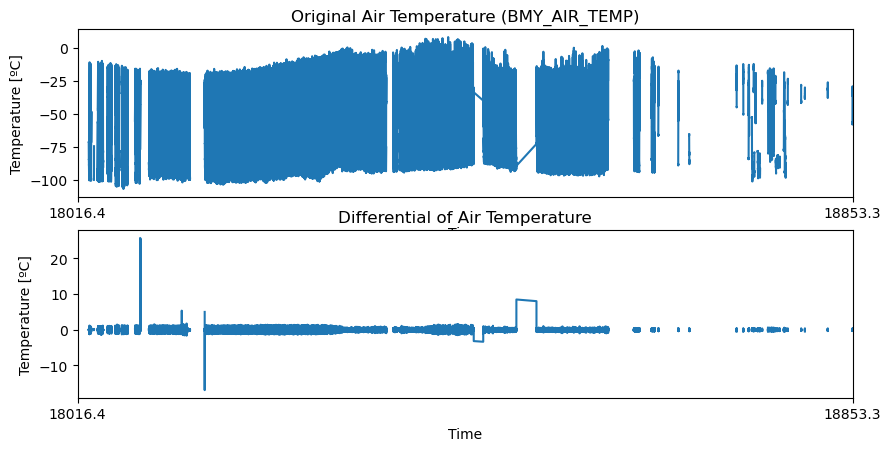

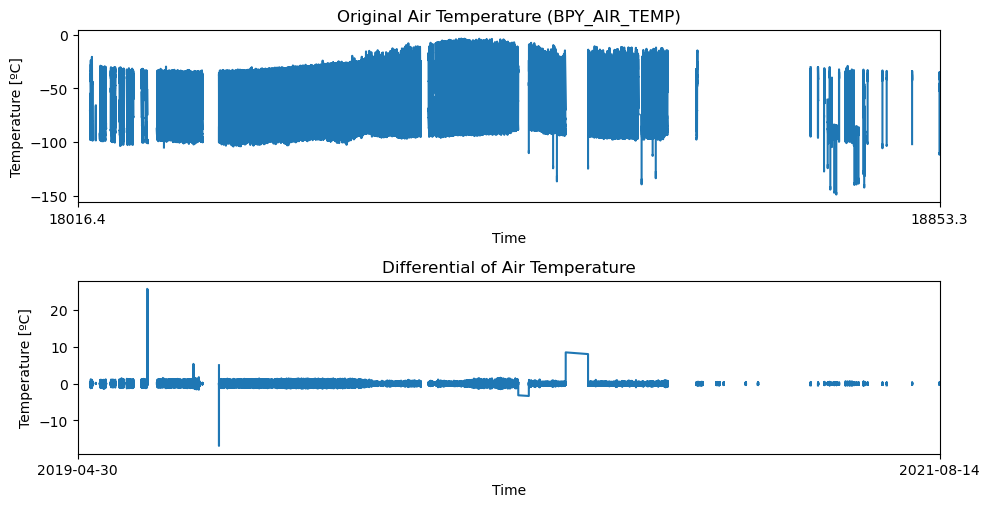

In [101]:
# 대기 온도 및 온도 변화량 시퀀스

x = environ_data1.UTC.values
y = environ_data1.BMY_AIR_TEMP.values
dx = np.gradient(y)
dy_dx = np.gradient(y, dx)

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(x, y, label='Original Data')
plt.title('Original Air Temperature (BMY_AIR_TEMP)')
plt.xlabel('Time')
plt.ylabel('Temperature [ºC]')
plt.xticks([x[0],x[-1]])
plt.xlim([x[0],x[-1]])

plt.subplot(4, 1, 2)
plt.plot(x, dx, label='Derivated')
plt.title('Differential of Air Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature [ºC]')
plt.xticks([x[0],x[-1]])
plt.xlim([x[0],x[-1]])

y_1 = environ_data1.BPY_AIR_TEMP.values
dx_1 = np.gradient(y)
dy_dx_1 = np.gradient(y, dx)

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(x, y_1, label='Original Data')
plt.title('Original Air Temperature (BPY_AIR_TEMP)')
plt.xlabel('Time')
plt.ylabel('Temperature [ºC]')
plt.xticks([x[0],x[-1]])
plt.xlim([x[0],x[-1]])

plt.subplot(4, 1, 4)
plt.plot(x, dx_1, label='Derivated')
plt.title('Differential of Air Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature [ºC]')
plt.xticks([x[0],x[-1]])
plt.xlim([x[0],x[-1]])


xfmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.tight_layout()
plt.show()

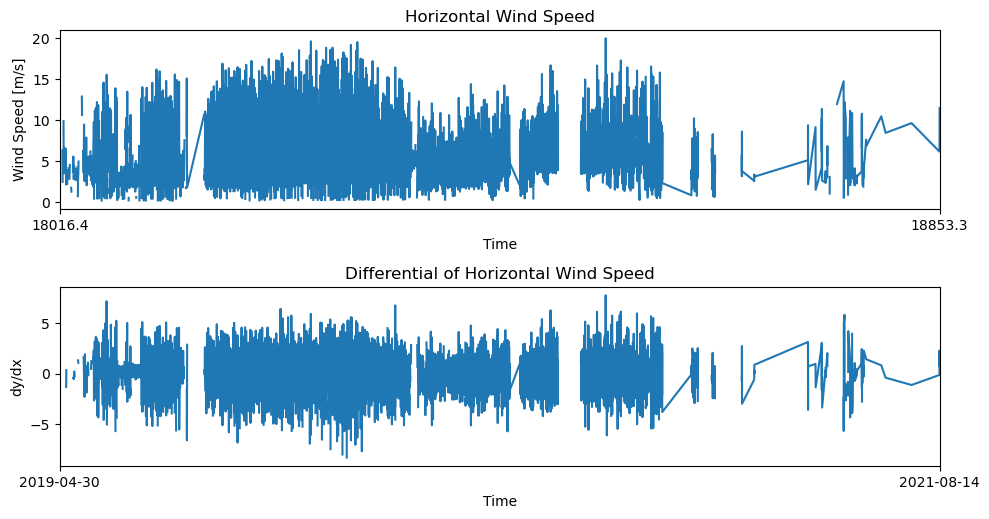

In [100]:
# 풍속 및 풍속 변화량 시퀀스

x2 = environ_data1.UTC[::3600].values
y2 = environ_data1.HORIZONTAL_WIND_SPEED[::3600].values
dx2 = np.gradient(y2)
dy_dx2 = np.gradient(y2, dx2)

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(x2, y2, label='Original Data')
plt.title('Horizontal Wind Speed')
plt.xlabel('Time')
plt.ylabel('Wind Speed [m/s]')
plt.xticks([x[0],x[-1]])
plt.xlim([x[0],x[-1]])

plt.subplot(4, 1, 2)
plt.plot(x2, dx2, label='Derivated')
plt.title('Differential of Horizontal Wind Speed')
plt.xlabel('Time')
plt.ylabel('dy/dx')
plt.xticks([x2[0],x2[-1]])
plt.xlim([x2[0],x2[-1]])


xfmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(xfmt)

'''
y2 = environ_data1.VERTICAL_WIND_SPEED[::3600].values
dx2 = np.gradient(y2)
dy_dx2 = np.gradient(y2, dx2)

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 3)
plt.plot(x2, y2, label='Original Data')
plt.title('Vertical Wind Speed')
plt.xlabel('Time')
plt.ylabel('Wind Speed [m/s]')
plt.xticks([x2[0],x2[-1]])
plt.xlim([x2[0],x2[-1]])

plt.subplot(4, 1, 4)
plt.plot(x2, dx2, label='Derivated')
plt.title('Derivated Vertical Wind Speed')
plt.xlabel('Time')
plt.ylabel('dy/dx')
plt.xticks([x2[0],x2[-1]])
plt.xlim([x2[0],x2[-1]])
'''
plt.tight_layout()
plt.show()

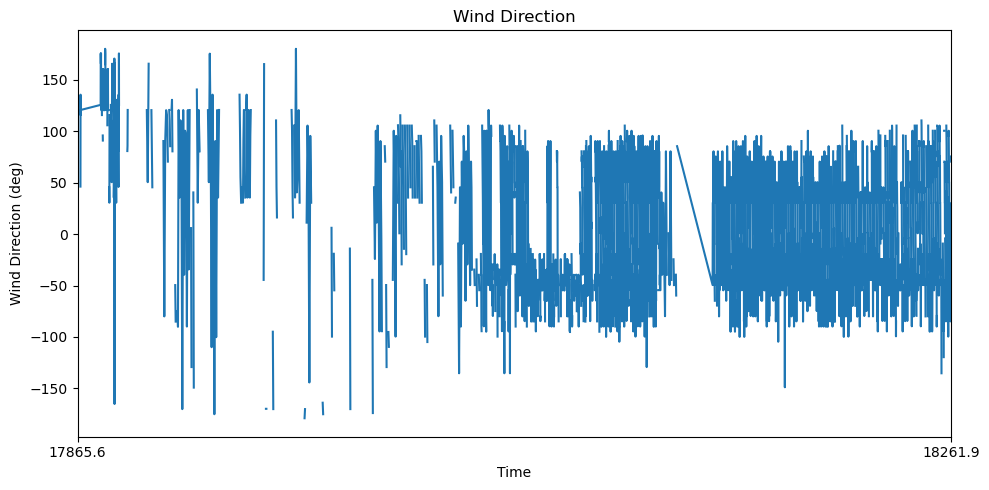

In [15]:
'''
# 풍향 시퀀스

x3 = environ_data1.UTC[::3600].values
y3 = environ_data1.WIND_DIRECTION[::3600].values

plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.plot(x3, y3, label='Original Data')
plt.title('Wind Direction')
plt.xlabel('Time')
plt.ylabel('Wind Direction (deg)')
plt.xticks([x3[0],x3[-1]])
plt.xlim([x3[0],x3[-1]])

plt.tight_layout()
plt.show()
'''

In [10]:
'''
# PS 기압 데이터
# https://atmos.nmsu.edu/data_and_services/atmospheres_data/INSIGHT/insight.html

environ_data2 = pd.read_csv('./insight_air_pressure_v2.csv')
environ_data2.drop(['Unnamed: 0'], axis=1, inplace = True)
environ_data2['UTC'] = environ_data2['UTC'].apply(lambda x: mdates.date2num(UTCDateTime(x)))
environ_data2
'''

AOBT          SCLK                LMST            LTST  \
0          616100331.7  6.161003e+08  00221M00:00:00.052  00220 23:54:12   
1          616100331.8  6.161003e+08  00221M00:00:00.149  00220 23:54:12   
2          616100331.9  6.161003e+08  00221M00:00:00.246  00220 23:54:12   
3          616100332.0  6.161003e+08  00221M00:00:00.344  00220 23:54:12   
4          616100332.1  6.161003e+08  00221M00:00:00.441  00220 23:54:12   
...                ...           ...                 ...             ...   
103002526  628529013.7  6.285288e+08  00360M23:59:59.541  00361 00:20:42   
103002527  628529013.8  6.285288e+08  00360M23:59:59.639  00361 00:20:42   
103002528  628529013.9  6.285288e+08  00360M23:59:59.736  00361 00:20:42   
103002529  628529014.0  6.285288e+08  00360M23:59:59.833  00361 00:20:42   
103002530  628529014.1  6.285288e+08  00360M23:59:59.931  00361 00:20:42   

                    UTC  PRESSURE  PRESSURE_FREQUENCY  PRESSURE_TEMP  \
0          18088.291427  776.5559                10.0            NaN   
1          18088.291428  776.5517                10.0            NaN   
2          18088.291430  776.5569                10.0            NaN   
3          18088.291431  776.5624                10.0            NaN   
4          18088.291432  776.5646                10.0            NaN   
...                 ...       ...                 ...            ...   
103002526  18232.140196  679.8473                10.0            NaN   
103002527  18232.140197  679.8513                10.0            NaN   
103002528  18232.140198  679.8499                10.0            NaN   
103002529  18232.140200  679.8362                10.0            NaN   
103002530  18232.140201  679.8154                10.0            NaN   

           PRESSURE_TEMP_FREQUENCY  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
103002526                      NaN  
103002527                      NaN  
103002528                      NaN  
103002529                      NaN  
103002530                      NaN  

[103002531 rows x 9 columns]

c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


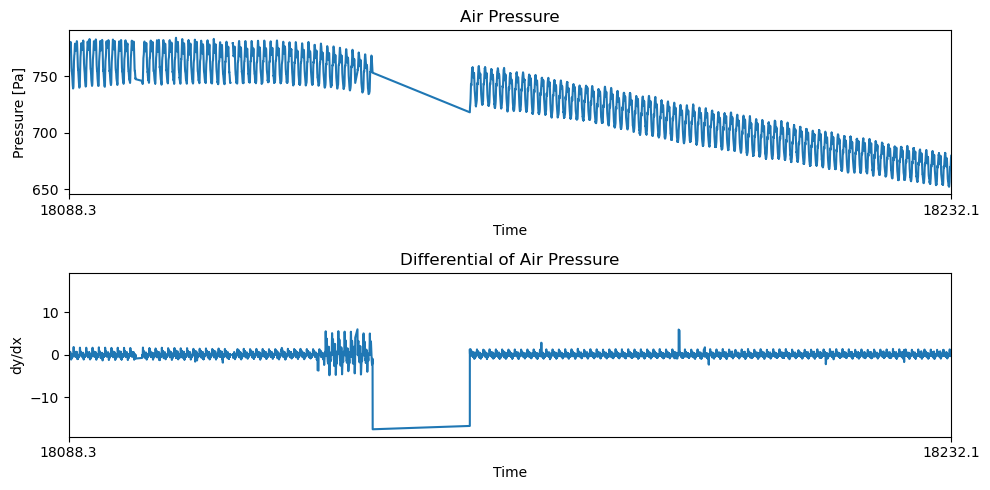

In [11]:
'''
##  기압 시퀀스

x4 = environ_data2.UTC[::3600].values
y4 = environ_data2['PRESSURE'][::3600].values

dx4 = np.gradient(y4)
dy_dx4 = np.gradient(y4, dx4)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(x4, y4, label='Original Data')
plt.title('Air Pressure')
plt.xlabel('Time')
plt.ylabel('Pressure [Pa]')
plt.xticks([x4[0],x4[-1]])
plt.xlim([x4[0],x4[-1]])

plt.subplot(2, 1, 2)
plt.plot(x4, dx4, label='Derivated')
plt.title('Differential of Air Pressure')
plt.xlabel('Time')
plt.ylabel('dy/dx')
plt.xticks([x4[0],x4[-1]])
plt.xlim([x4[0],x4[-1]])

plt.tight_layout()
plt.show()
'''

In [26]:
# HP^3 표면 (Brightness) 온도 데이터

environ_data3 = pd.read_csv('./insight_surface_temperature.csv')
environ_data3.drop(['Unnamed: 0'], axis=1, inplace = True)
environ_data3.columns = ['Datetime', 'Sol', 'Mars True Local Solar Time', 'Solar longitude LS (degree)', 'Sun Azimuth (degree)','Sun Phase angle FOV 1 (degree)', 'Incidence angle FOV 1', 'Sigma Sun Phase angle FOV 1',
                         'Sigma Incidence angle FOV 1', 'Shadow FOV 1', 'Sun Phase angle FOV 2', 'Incidence angle FOV 2',
                         'Sigma Sun Phase angle FOV 2', 'Sigma Incidence angle FOV 2', 'Shadow FOV 2','TS FoV 1',
                         'TS FoV 2', 'DTS FoV 1', 'DTS FoV 2']
#environ_data3['Datetime'] = environ_data3['Datetime'].apply(lambda x: mdates.date2num(UTCDateTime(x)))
#environ_data3 = environ_data3.dropna(subset=['TS FoV 1'])
#environ_data3['TS FoV 1'] -= 273 
#environ_data3 = environ_data3.iloc[6500:165000]
environ_data3

Datetime  Sol  Mars True Local Solar Time  \
0       2018-12-11T07:30:42.598Z   14                     15.8856   
1       2018-12-11T07:30:57.240Z   14                     15.8894   
2       2018-12-11T07:31:11.882Z   14                     15.8936   
3       2018-12-11T07:31:26.523Z   14                     15.8975   
4       2018-12-11T07:31:41.165Z   14                     15.9014   
...                          ...  ...                         ...   
267758  2021-09-17T04:40:40.537Z  998                     12.9547   
267759  2021-09-17T04:40:55.178Z  998                     12.9586   
267760  2021-09-17T04:41:09.820Z  998                     12.9625   
267761  2021-09-17T04:41:24.462Z  998                     12.9667   
267762  2021-09-17T04:41:39.103Z  998                     12.9706   

        Solar longitude LS (degree)  Sun Azimuth (degree)  \
0                            304.29                 244.1   
1                            304.29                 244.1   
2                            304.29                 244.1   
3                            304.29                 244.1   
4                            304.29                 244.1   
...                             ...                   ...   
267758                       100.27                 326.6   
267759                       100.27                 326.5   
267760                       100.27                 326.4   
267761                       100.27                 326.3   
267762                       100.27                 326.2   

        Sun Phase angle FOV 1 (degree)  Incidence angle FOV 1  \
0                                 66.7                   64.2   
1                                 66.8                   64.3   
2                                 66.8                   64.3   
3                                 66.9                   64.4   
4                                 66.9                   64.4   
...                                ...                    ...   
267758                            63.5                   28.5   
267759                            63.5                   28.6   
267760                            63.5                   28.6   
267761                            63.5                   28.7   
267762                            63.6                   28.7   

        Sigma Sun Phase angle FOV 1  Sigma Incidence angle FOV 1  \
0                               3.0                          0.0   
1                               3.0                          0.0   
2                               3.0                          0.0   
3                               3.0                          0.0   
4                               3.0                          0.0   
...                             ...                          ...   
267758                          2.9                          0.0   
267759                          2.9                          0.0   
267760                          2.9                          0.0   
267761                          2.9                          0.0   
267762                          2.9                          0.0   

        Shadow FOV 1  Sun Phase angle FOV 2  Incidence angle FOV 2  \
0              100.0                   75.5                   64.2   
1              100.0                   75.5                   64.3   
2              100.0                   75.5                   64.3   
3              100.0                   75.5                   64.4   
4              100.0                   75.6                   64.4   
...              ...                    ...                    ...   
267758           0.0                   92.1                   28.5   
267759           0.0                   92.1                   28.6   
267760           0.0                   92.2                   28.6   
267761           0.0                   92.2                   28.7   
267762           0.0                   92.2                   28.7   

        Sigma Sun Phase

In [27]:
# Ensure the Datetime column is in datetime format
environ_data3['Datetime'] = pd.to_datetime(environ_data3['Datetime'])

# Set the Datetime column as the index
environ_data3.set_index('Datetime', inplace=True)
print(environ_data3.head(5))
# Resample the data to an hourly frequency
environ_data3_resampled = environ_data3.resample('30min').mean()
print(environ_data3.head(5))
environ_data3_resampled.reset_index(inplace=True)
environ_data3_resampled['Datetime'] = environ_data3_resampled['Datetime'].apply(lambda x: mdates.date2num(UTCDateTime(x)))
environ_data3_resampled['TS FoV 1'] = environ_data3_resampled['TS FoV 1'].apply(lambda x: x - 273)
environ_data3_resampled

                                  Sol  Mars True Local Solar Time  \
Datetime                                                            
2018-12-11 07:30:42.598000+00:00   14                     15.8856   
2018-12-11 07:30:57.240000+00:00   14                     15.8894   
2018-12-11 07:31:11.882000+00:00   14                     15.8936   
2018-12-11 07:31:26.523000+00:00   14                     15.8975   
2018-12-11 07:31:41.165000+00:00   14                     15.9014   

                                  Solar longitude LS (degree)  \
Datetime                                                        
2018-12-11 07:30:42.598000+00:00                       304.29   
2018-12-11 07:30:57.240000+00:00                       304.29   
2018-12-11 07:31:11.882000+00:00                       304.29   
2018-12-11 07:31:26.523000+00:00                       304.29   
2018-12-11 07:31:41.165000+00:00                       304.29   

                                  Sun Azimuth (degree)  \
Da

Datetime    Sol  Mars True Local Solar Time  \
0      17876.312500   14.0                   15.929126   
1      17876.333333    NaN                         NaN   
2      17876.354167   14.0                   16.929126   
3      17876.375000    NaN                         NaN   
4      17876.395833   14.0                   17.928648   
...             ...    ...                         ...   
48518  18887.104167    NaN                         NaN   
48519  18887.125000    NaN                         NaN   
48520  18887.145833    NaN                         NaN   
48521  18887.166667    NaN                         NaN   
48522  18887.187500  998.0                   12.926983   

       Solar longitude LS (degree)  Sun Azimuth (degree)  \
0                           304.29            244.252174   
1                              NaN                   NaN   
2                           304.32            247.660870   
3                              NaN                   NaN   
4                           304.34            249.434783   
...                            ...                   ...   
48518                          NaN                   NaN   
48519                          NaN                   NaN   
48520                          NaN                   NaN   
48521                          NaN                   NaN   
48522                       100.27            327.321739   

       Sun Phase angle FOV 1 (degree)  Incidence angle FOV 1  \
0                           67.273913              64.817391   
1                                 NaN                    NaN   
2                           79.669565              78.678261   
3                                 NaN                    NaN   
4                           91.534783              92.678261   
...                               ...                    ...   
48518                             NaN                    NaN   
48519                             NaN                    NaN   
48520                             NaN                    NaN   
48521                             NaN                    NaN   
48522                       63.269565              28.304348   

       Sigma Sun Phase angle FOV 1  Sigma Incidence angle FOV 1  Shadow FOV 1  \
0                              3.0                          0.0         100.0   
1                              NaN                          NaN           NaN   
2                              3.0                          0.0           0.0   
3                              NaN                          NaN           NaN   
4                              3.0                          0.0           0.0   
...                            ...                          ...           ...   
48518                          NaN                          NaN           NaN   
48519                          NaN                          NaN           NaN   
48520                          NaN                          NaN           NaN   
48521                          NaN                          NaN           NaN   
48522                          2.9                          0.0           0.0   

       Sun Phase angle FOV 2  Incidence angle FOV 2  \
0                  75.795652              64.817391   
1                        NaN                    NaN   
2                  83.386957              78.678261   
3                        NaN                    NaN   
4                  90.160870              92.678261   
...                      ...                    ...   
48518                    NaN                    NaN   
48519                    NaN                    NaN   
48520                    NaN                    NaN   
48521                    NaN                    NaN   
48522              91.956522              28.304348   

       Sigma Sun Phase angle FOV 2  Sigma Incidence angle FOV 2  Shadow FOV 2  \
0                              3.0                          0.0           0.0   
1                           

c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1244: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\neimb\anaconda3\Lib\site-p

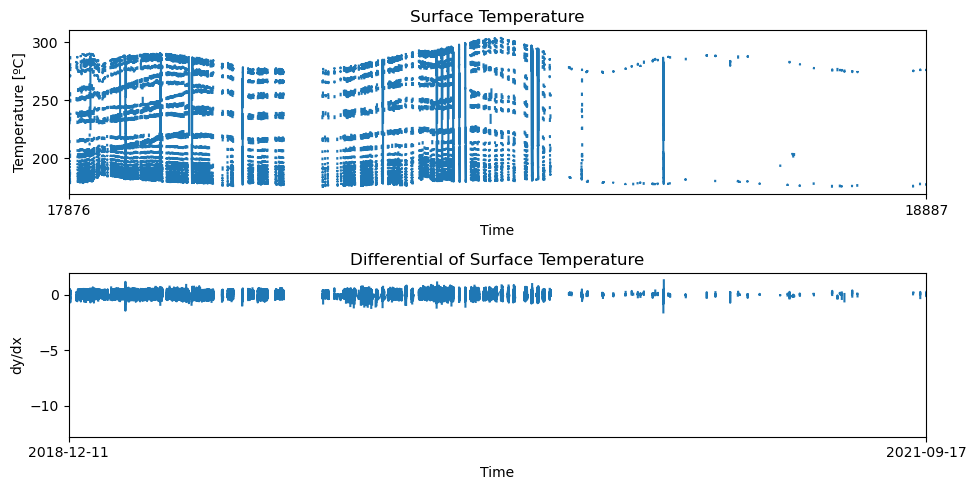

In [139]:
# 표면 온도 시퀀스

x5 = environ_data3_resampled.Datetime[:].values
y5 = environ_data3_resampled['TS FoV 1'][:].values

dx5 = np.gradient(y5)
dy_dx5 = np.gradient(y5, dx5)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(x5, y5, label='Original Data')
plt.title('Surface Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature [ºC]')
plt.xticks([x5[0],x5[-1]])
plt.xlim([x5[0],x5[-1]])

plt.subplot(2, 1, 2)
plt.plot(x5, dx5, label='Derivated')
plt.title('Differential of Surface Temperature')
plt.xlabel('Time')
plt.ylabel('dy/dx')
plt.xticks([x5[0],x5[-1]])
plt.xlim([x5[0],x5[-1]])

xfmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.tight_layout()
plt.show()

---
# 화성 연속파형 데이터

- VBB의 속도 자료(BHU,V,W)는 처음에는 10sps이지만 sol 182(2019.6.2) ~ 미션 종료까지 20sps로 운용  
- 10sps 자료는 initial, 20sps 자료는 U(V,W)_component 변수에 저장  
  
  
   
- 배경잡음을 주파수 별로(0.1 ~ 1, 1 ~ 10Hz) 추출한 후 특성 및 diurnal variation 여부 확인 
- 일변화, 연변화 나타나면 앞서 불러온 표면 환경 데이터와 비교

In [ ]:
# 10sps 자료 (미사용)

initial = PPSD.load_npz('mars2019_initial.npz')
initial.plot(xaxis_frequency=True, period_lim= (5, 0.001) ,max_percentage=5, grid=False);

In [11]:
# 20sps 자료 (with solution by McNamara & Buland, 2004)

U_component = PPSD.load_npz('mars2019_BHU_noskip.npz')
U_component.add_npz('mars2020_1_BHU_noskip.npz')
U_component.add_npz('mars2020_2_BHU_noskip.npz')
U_component.add_npz('mars2021_1_BHU_noskip.npz')
U_component.add_npz('mars2021_2_BHU_noskip.npz')
U_component.add_npz('mars2022_1_BHU_noskip.npz')
U_component.add_npz('mars2022_2_BHU_noskip.npz')


V_component = PPSD.load_npz('mars2019_BHV.npz')
V_component.add_npz('mars2020_1_BHV.npz')
V_component.add_npz('mars2020_2_BHV.npz')
V_component.add_npz('mars2021_1_BHV.npz')
V_component.add_npz('mars2021_2_BHV.npz')
V_component.add_npz('mars2022_1_BHV.npz')
V_component.add_npz('mars2022_2_BHV.npz')

W_component = PPSD.load_npz('mars2019_BHW.npz')
W_component.add_npz('mars2020_1_BHW.npz')
W_component.add_npz('mars2020_2_BHW.npz')
W_component.add_npz('mars2021_1_BHW.npz')
W_component.add_npz('mars2021_2_BHW.npz')
W_component.add_npz('mars2022_1_BHW.npz')
W_component.add_npz('mars2022_2_BHW.npz')

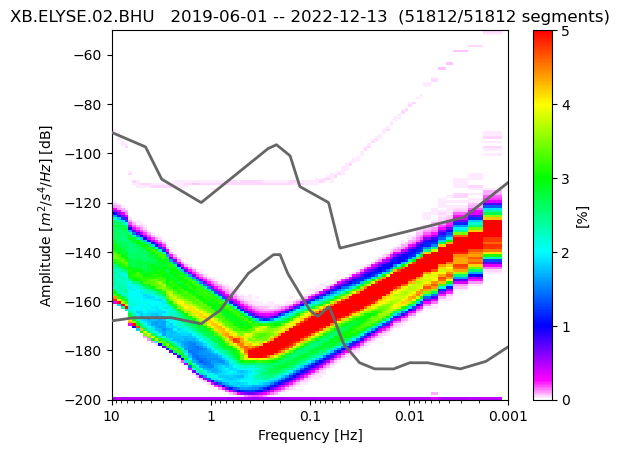

In [156]:
U_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False, show_coverage= False, cmap = pqlx);
#V_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False);
#W_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False);

In [ ]:
manual_plot_spectrogram(U_component, grid=False, cmap='jet');

---
# 화성 일일 데이터 (1.0 ~ 10Hz)

In [160]:
# PSD 일일 단위로 뽑아서 중첩 후 median 도출, 푸리에 급수 피팅을 통해 median 그래프와 비교

start= []
end= []

starttime = UTCDateTime("2019-10-08T00:00:00")
endtime = UTCDateTime("2019-10-09T00:00:00") + ((60 * 39) + 35)

daily_time = []
daily_data = []

for i in range(730):
    
    U_component = PPSD.load_npz('mars2019_BHU_noskip.npz')
    U_component.add_npz('mars2020_1_BHU_noskip.npz')
    U_component.add_npz('mars2020_2_BHU_noskip.npz')
    U_component.add_npz('mars2021_1_BHU_noskip.npz')
    U_component.add_npz('mars2021_2_BHU_noskip.npz')
    U_component.add_npz('mars2022_1_BHU_noskip.npz')
    U_component.add_npz('mars2022_2_BHU_noskip.npz')
    
    mask = U_component._stack_selection(starttime=starttime, endtime=endtime)
    U_component._times_processed = [t for i, t in enumerate(U_component._times_processed) if mask[i]]
    U_component._binned_psds = [t for i, t in enumerate(U_component._binned_psds) if mask[i]]
    #U_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False)
    
    
    try:
        fre = U_component.get_percentile()[0]
    except :
        pass
    
    # 주파수 선택
    freq = np.where((fre < 1 / 2.0) & (fre > 1 / 3.0))
    avg_amplitude = []
    time = []

    #utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    #mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    for i in range(len(U_component.psd_values)):
        time.append(UTCDateTime(int(str(U_component._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
        avg_amplitude.append(np.median(U_component.psd_values[i][freq[0][0]:freq[0][-1]]))

    if len(U_component._binned_psds) == 49:
        daily_time.append(time)
        daily_data.append(avg_amplitude)
    
    print(f'{starttime, endtime, len(U_component._binned_psds)}')
    start.append(starttime)
    end.append(endtime)

    starttime = endtime
    endtime += ((60 * 60 * 24) + (60 * 39) + 35)

(UTCDateTime(2019, 10, 8, 0, 0), UTCDateTime(2019, 10, 9, 0, 39, 35), 49)
(UTCDateTime(2019, 10, 9, 0, 39, 35), UTCDateTime(2019, 10, 10, 1, 19, 10), 46)
(UTCDateTime(2019, 10, 10, 1, 19, 10), UTCDateTime(2019, 10, 11, 1, 58, 45), 50)
(UTCDateTime(2019, 10, 11, 1, 58, 45), UTCDateTime(2019, 10, 12, 2, 38, 20), 49)
(UTCDateTime(2019, 10, 12, 2, 38, 20), UTCDateTime(2019, 10, 13, 3, 17, 55), 47)
(UTCDateTime(2019, 10, 13, 3, 17, 55), UTCDateTime(2019, 10, 14, 3, 57, 30), 50)
(UTCDateTime(2019, 10, 14, 3, 57, 30), UTCDateTime(2019, 10, 15, 4, 37, 5), 49)
(UTCDateTime(2019, 10, 15, 4, 37, 5), UTCDateTime(2019, 10, 16, 5, 16, 40), 49)
(UTCDateTime(2019, 10, 16, 5, 16, 40), UTCDateTime(2019, 10, 17, 5, 56, 15), 47)
(UTCDateTime(2019, 10, 17, 5, 56, 15), UTCDateTime(2019, 10, 18, 6, 35, 50), 49)
(UTCDateTime(2019, 10, 18, 6, 35, 50), UTCDateTime(2019, 10, 19, 7, 15, 25), 49)
(UTCDateTime(2019, 10, 19, 7, 15, 25), UTCDateTime(2019, 10, 20, 7, 55), 47)
(UTCDateTime(2019, 10, 20, 7, 55), UTCDate

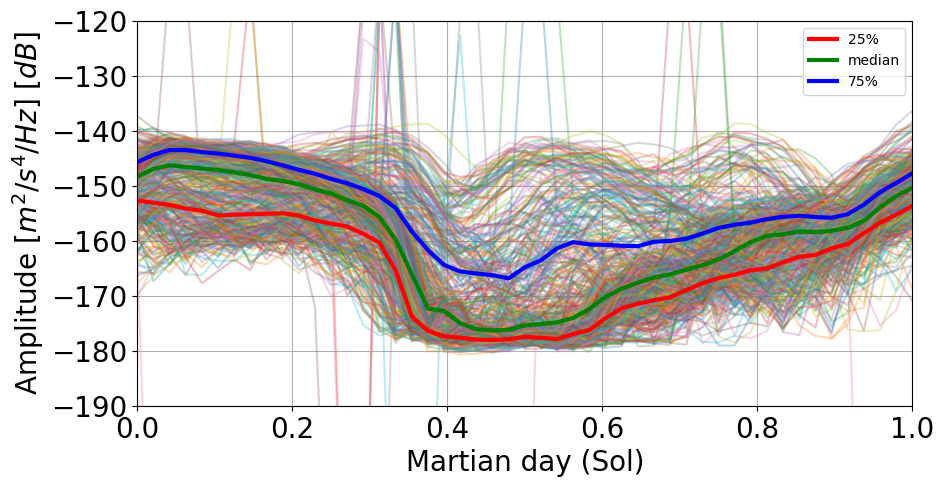

In [161]:
plt.figure(figsize=(10,5))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.3);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 3, color ='g', label = 'median')
plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()


C:\Users\neimb\AppData\Local\Temp\ipykernel_31980\203959348.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return (1 / T) * quad(median_func, 0, T)[0]
C:\Users\neimb\AppData\Local\Temp\ipykernel_31980\203959348.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

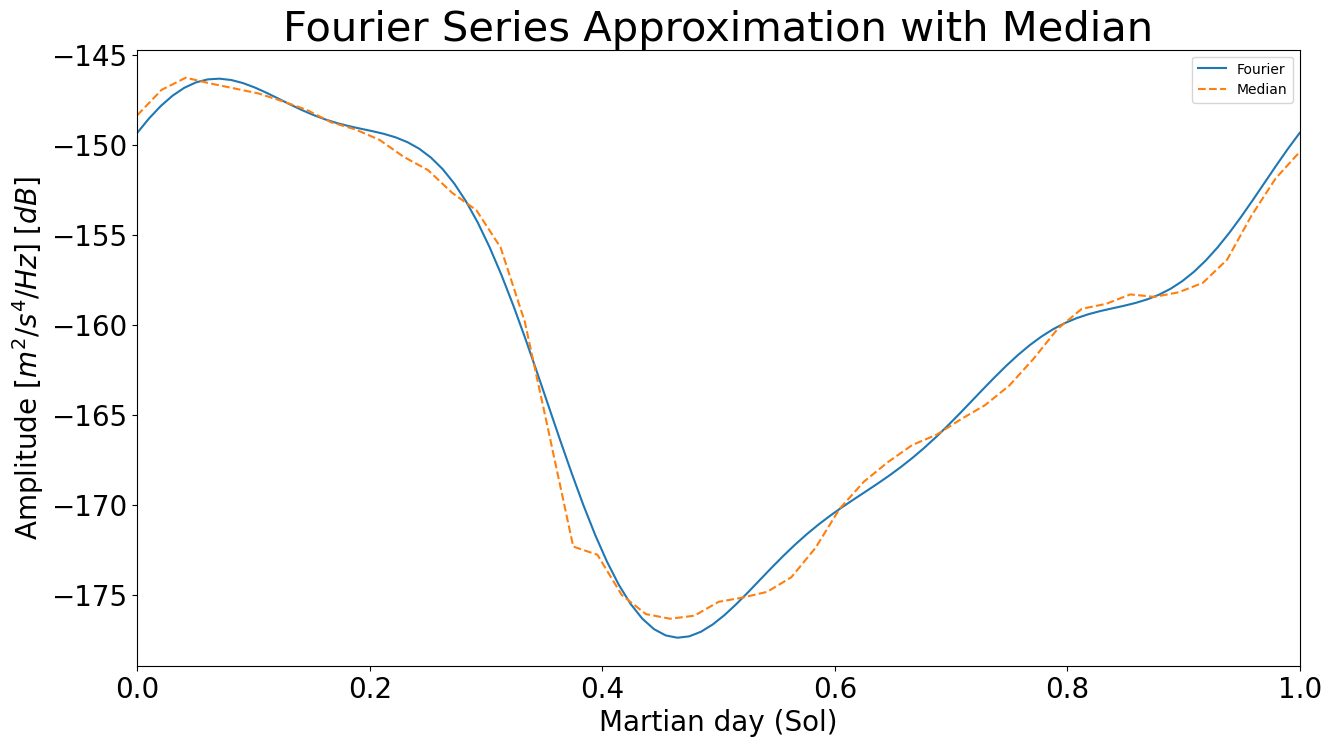

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 주기
T = 1 # 주기 T를 설정

# median 값을 함수로 정의
def median_func(x):
    idx = int(x / T * len(median)) % len(median)
    return median[idx]

# a0 계산 
def a0(T, median_func):
    return (1 / T) * quad(median_func, 0, T)[0]

# an 계산 (n차 푸리에 계수, cos 성분)
def an(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.cos(2 * np.pi * n * x / T), 0, T)[0]

# bn 계산 (n차 푸리에 계수, sin 성분)
def bn(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.sin(2 * np.pi * n * x / T), 0, T)[0]

# 푸리에 급수로 근사한 함수
def fourier_series(x, terms, T, median_func):
    result = a0(T, median_func)
    for n in range(1, terms + 1): # terms는 몇 번 더할건지
        result += an(n, T, median_func) * np.cos(2 * np.pi * n * x / T) + bn(n, T, median_func) * np.sin(2 * np.pi * n * x / T)
    return result


# 푸리에 급수 계산
x_vals = np.linspace(0, T, 100)
y_fourier = [fourier_series(x, 4, T, median_func) for x in x_vals]  # 각 x 값에 대해 푸리에 급수 계산

# 결과 시각화
plt.figure(figsize=(15,8))
plt.plot(x_vals, y_fourier, label='Fourier')
plt.plot(time, median, label='Median', linestyle='--')
plt.legend()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Fourier Series Approximation with Median', fontsize = 30)
plt.xlim(time[0], time[-1])
plt.show()

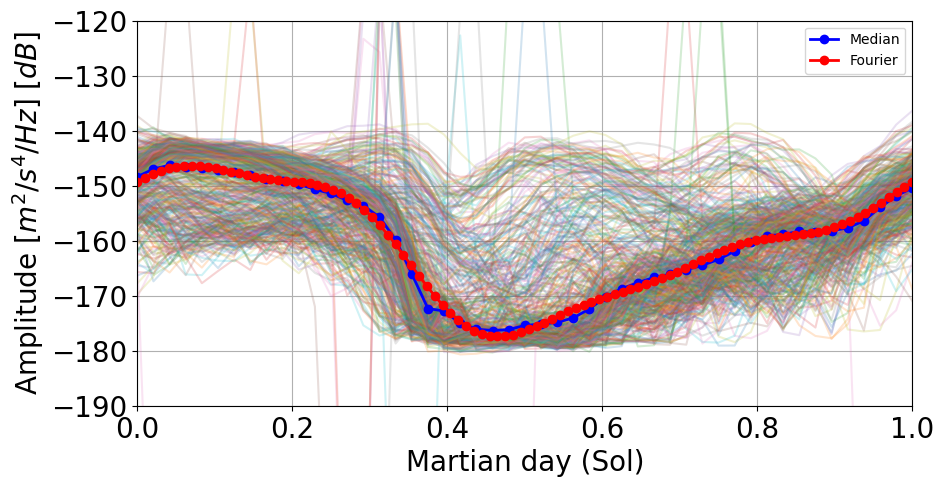

In [164]:
plt.figure(figsize=(10,5))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.2);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
#plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 2, color ='b', marker = 'o', label = 'Median')
#plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')
plt.plot(x_vals, y_fourier, linewidth = 2, color ='red',  marker = 'o',label='Fourier')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()

In [149]:
from tqdm import tqdm

# 두 번째 서브플롯: lmst_groups의 TC12
env_data3 = environ_data3_resampled

lmst_groups = {}

# Iterate over each row in the dataframe
for start_time, end_time in tqdm(zip(start, end), total=len(start)):
    lmst_prefix = start_time.strftime("%Y%m%d")
    if lmst_prefix not in lmst_groups:
        lmst_groups[lmst_prefix] = []

    for index, row in env_data3.iterrows():
        if start_time < UTCDateTime(mdates.num2date(row['Datetime'])) < end_time:
            lmst_groups[lmst_prefix].append(row)


  0%|          | 0/730 [00:00<?, ?it/s]

100%|██████████| 730/730 [1:15:26<00:00,  6.20s/it]


In [218]:
from tqdm import tqdm

# 두 번째 서브플롯: lmst_groups의 TC12
env_data1 = environ_data1_resampled

lmst_groups2 = {}

# Iterate over each row in the dataframe
for start_time, end_time in tqdm(zip(start, end), total=len(start)):
    lmst_prefix2 = start_time.strftime("%Y%m%d")
    if lmst_prefix2 not in lmst_groups2:
        lmst_groups2[lmst_prefix2] = []

    for index, row in env_data1.iterrows():
        if start_time < UTCDateTime(mdates.num2date(row['UTC'])) < end_time:
            lmst_groups2[lmst_prefix2].append(row)


NameError: name 'environ_data1_resampled' is not defined

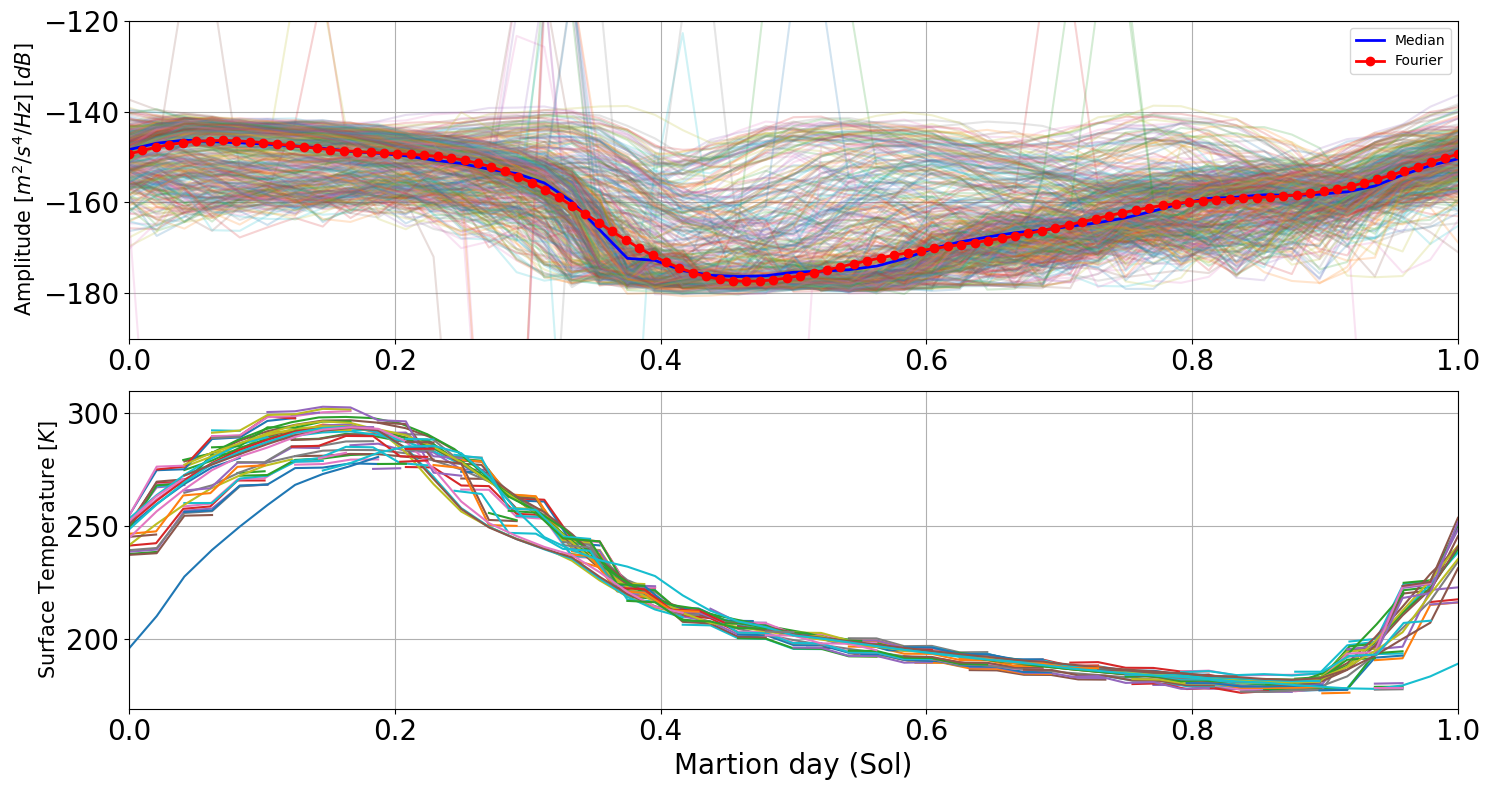

In [165]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# 첫 번째 서브플롯: daily_data와 median, Fourier series
time = np.linspace(0, 1, 49)
for day in range(len(daily_data)):
    axs[0].plot(time, daily_data[day], alpha=0.2)

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))

axs[0].plot(time, median, linewidth=2, color='b', label='Median')
axs[0].plot(x_vals, y_fourier, linewidth=2, color='red', marker='o', label='Fourier')

axs[0].legend(loc='best')
axs[0].set_xlim(0, 1)

axs[0].set_ylim(-190, -120)
axs[0].set_ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize=15)
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].grid()

# Convert lists to DataFrames
for key in lmst_groups:
    lmst_groups[key] = pd.DataFrame(lmst_groups[key])

# Display the grouped data
for key, group in lmst_groups.items():
    time = np.linspace(0, 1, len(group))
    if len(group) != 0:
        plt.plot(time, group['TS FoV 1'])

axs[1].set_xlim(0, 1)
axs[0].set_ylim(-190, -120)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].grid()
axs[1].set_xlabel('Martion day (Sol)', fontsize=20)
axs[1].set_ylabel('Surface Temperature [$K$]', fontsize=15)


# Convert lists to DataFrames
for key in lmst_groups2:
    lmst_groups2[key] = pd.DataFrame(lmst_groups2[key])

# Display the grouped data
for key, group in lmst_groups2.items():
    time = np.linspace(0, 1, len(group))
    if len(group) != 0:
        plt.plot(time, group['HORIZONTAL_WIND_SPEED'])

axs[2].set_xlim(0, 1)
axs[2].tick_params(axis='x', labelsize=20)
axs[2].tick_params(axis='y', labelsize=20)
axs[2].grid()
axs[2].set_xlabel('Martion day (Sol)', fontsize=20)
axs[2].set_ylabel('Horizontal wind speed [$m/s$]', fontsize=15)


plt.tight_layout()
plt.show()

In [178]:
import numpy as np
import matplotlib.pyplot as plt

def draw_periodicity5(ppsd, freq_min, freq_max, percentage, ylim_min, ylim_max):
    fre = ppsd.get_percentile()[0]

    # Ensure fre is a numpy array
    fre = np.array(fre, dtype=np.float64)

    freq = np.where((fre < 1 / freq_min) & (fre > 1 / freq_max))

    avg_amplitude = []
    time = ppsd.current_times_used
    time = mdates.date2num([UTCDateTime(t).datetime for t in time])

    for i in range(len(ppsd.psd_values)):
        # Ensure ppsd.psd_values[i] is a numpy array
        psd_values = np.array(ppsd.psd_values[i], dtype=np.float64)
        avg_amplitude.append(np.percentile(psd_values[int(freq[0][0]):int(freq[0][-1])], percentage))

    # Remove values from avg_amplitude that are less than -250 and their corresponding times
    filtered_avg_amplitude = [amp for amp in avg_amplitude if amp >= -250]
    filtered_time = [time[i] for i in range(len(avg_amplitude)) if avg_amplitude[i] >= -250]
    avg_amplitude = filtered_avg_amplitude
    time = filtered_time

    # Apply a 24-point moving average filter to avg_amplitude
    avg_amplitude_filtered = np.convolve(avg_amplitude, np.ones(48)/48, mode='valid')
    time_filtered = time[:len(avg_amplitude_filtered)]
  
    fig, ax = plt.subplots(figsize=(20, 10))

    plt.style.use(['default'])
    print(len(time_filtered))
    line1 = ax.plot(time_filtered, avg_amplitude_filtered, linewidth=0.5, color='black', label='median')
    ax.tick_params(axis='both', which='major', labelsize=18)

    #ax.set_xlabel('UTCDateTime', size=20, loc='right')
    ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]', size=20)
    ax.set_title('XA.S15..MHZ [1972-01-01 ~ 1974-12-31]', size=25)
    ax.set_xlim(time_filtered[0], time_filtered[-1])
    ax.set_ylim(ylim_min, ylim_max)

    ax.grid()

    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    fig.autofmt_xdate()
    
    return avg_amplitude_filtered, time_filtered

32426


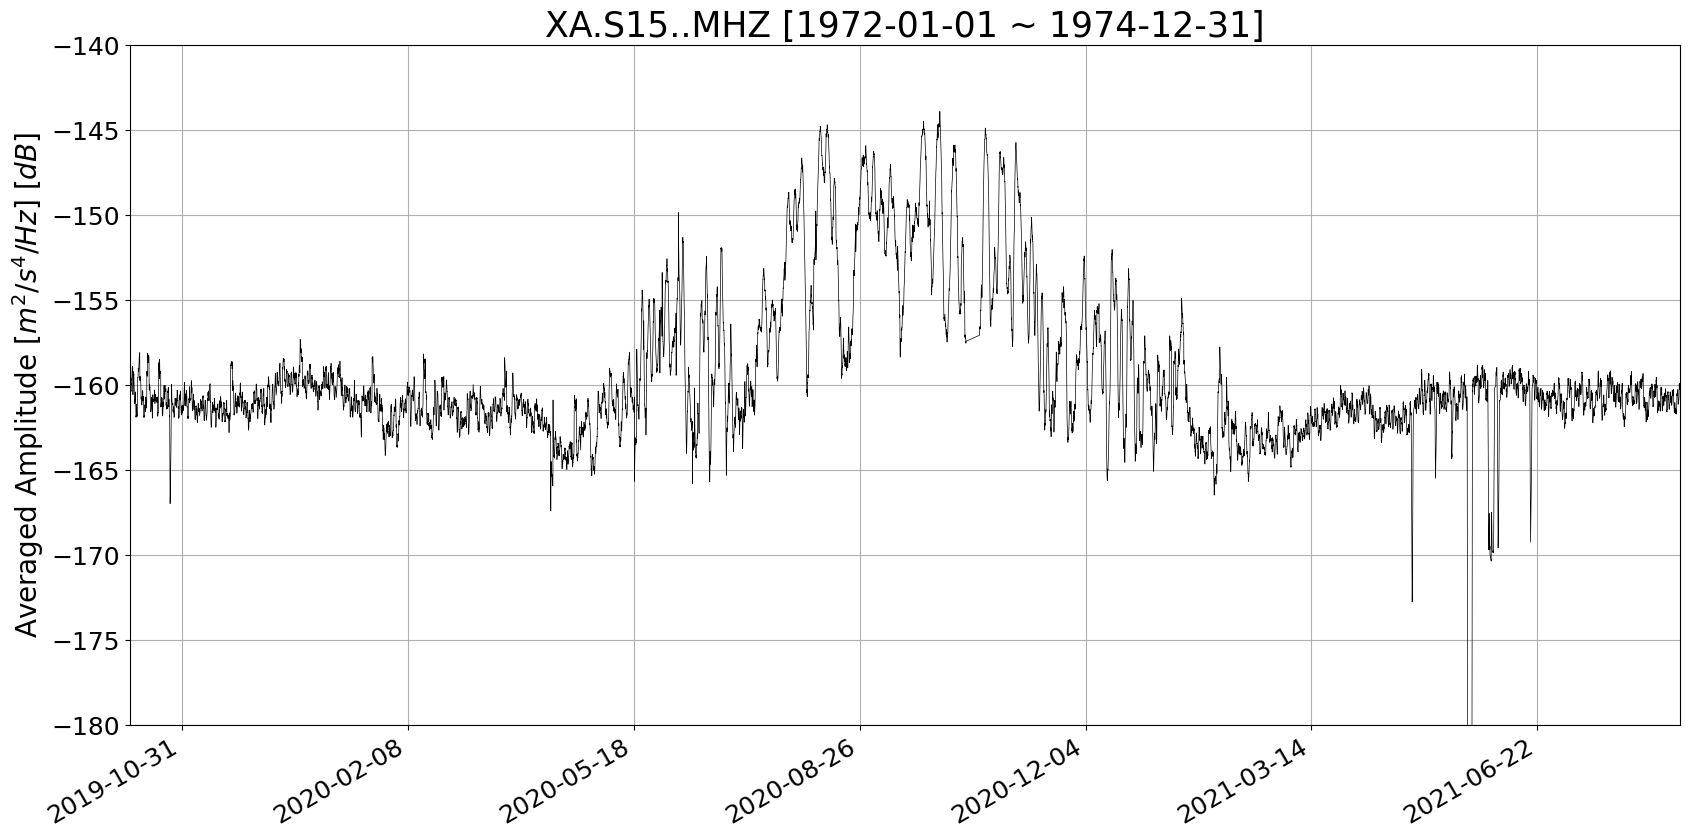

In [182]:
median_amplitude, tt = draw_periodicity5(U_component_temp, 2.0, 3.0, 50, ylim_min = -180, ylim_max = -140)

Calculating Fourier Series:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\neimb\AppData\Local\Temp\ipykernel_31980\3822022381.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return (1 / T) * quad(median_func, 0, T)[0]
C:\Users\neimb\AppData\Local\Temp\ipykernel_31980\3822022381.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return (2 / T) * quad(lambda x: median_func(x) * np.cos(2 * np.pi * n * x / T), 0, T)[0]
C:\Users\neimb\AppData\Local\Temp\ipykernel_31980\3822022381.py:26: IntegrationWarning: The maximum number of subdivisions (

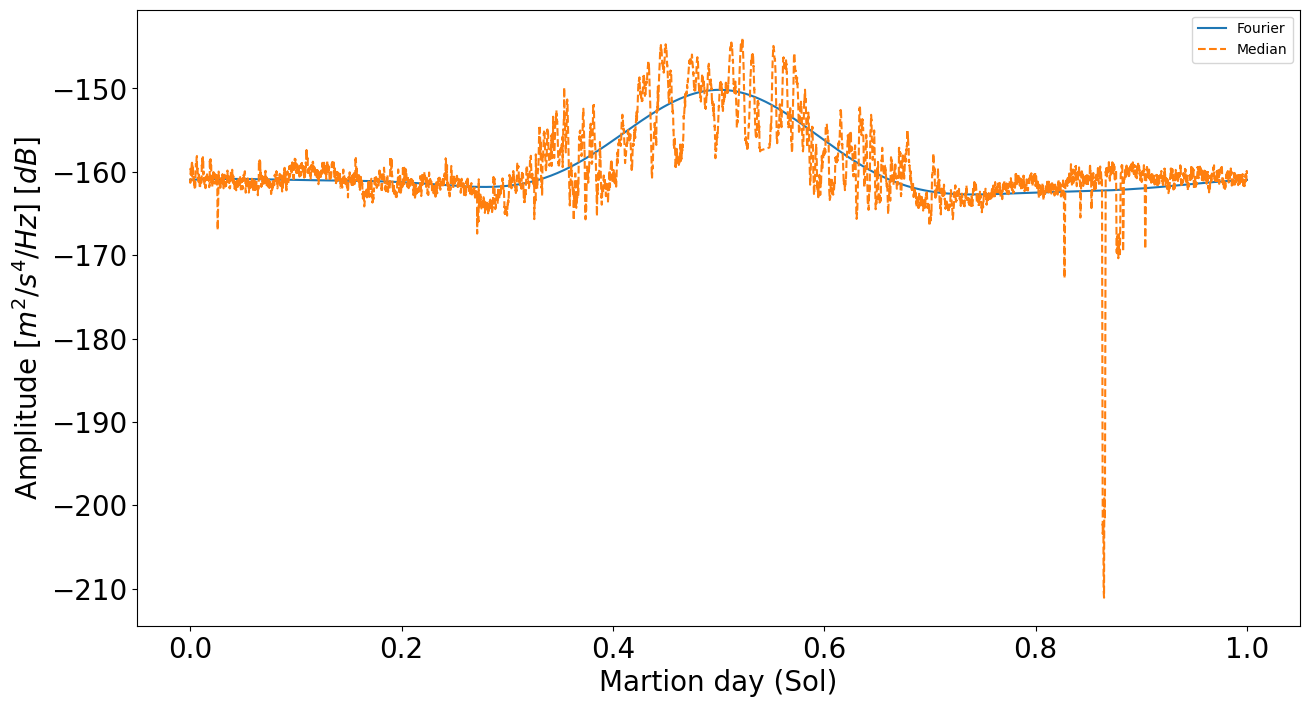

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm

#median_amplitude = list(median_amplitude)

# 주기
T = 1

# median 값을 함수로 정의
def median_func(x):
    idx = int(x / T * len(median_amplitude)) % len(median_amplitude)
    return median_amplitude[idx]

# a0 계산 
def a0(T, median_func):
    return (1 / T) * quad(median_func, 0, T)[0]

# an 계산 (n차 푸리에 계수, cos 성분)
def an(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.cos(2 * np.pi * n * x / T), 0, T)[0]

# bn 계산 (n차 푸리에 계수, sin 성분)
def bn(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.sin(2 * np.pi * n * x / T), 0, T)[0]

# 푸리에 급수로 근사한 함수
def fourier_series(x, terms, T, median_func):
    result = a0(T, median_func)
    for n in range(1, terms + 1): # terms는 몇 번 더할건지
        result += an(n, T, median_func) * np.cos(2 * np.pi * n * x / T) + bn(n, T, median_func) * np.sin(2 * np.pi * n * x / T)
    return result

# 푸리에 급수 계산
x_vals = np.linspace(0, 1.0, 1000)
y_fourier = [fourier_series(x, 4, T, median_func) for x in tqdm(x_vals, desc="Calculating Fourier Series")]

# tt 0~1사이로 정규화
tt_normalized = (tt - min(tt)) / (max(tt) - min(tt))

# 결과 시각화
plt.figure(figsize=(15,8))
plt.plot(x_vals, y_fourier, label='Fourier')
plt.plot(tt_normalized, median_amplitude, label='Median', linestyle='--')
plt.legend()
plt.xlabel('Martion day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.xlim(time[0], time[-1])
plt.show()


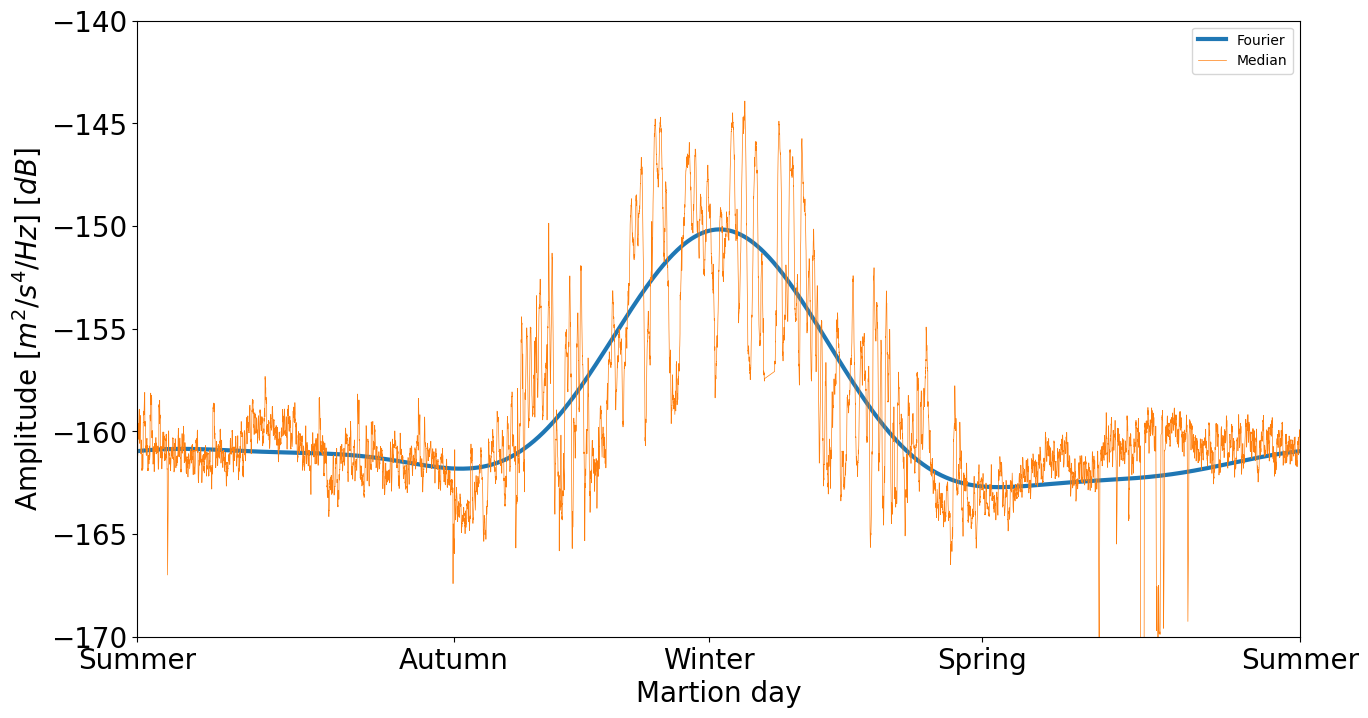

In [205]:
plt.figure(figsize=(15,8))
plt.plot(x_vals, y_fourier, label='Fourier', linewidth = 3)
plt.plot(tt_normalized, median_amplitude, label='Median', linestyle='-', linewidth = 0.5)
plt.legend()
plt.xlabel('Martion day', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.xticks([0.0, 0.2723740208474681, 0.2723740208474681+ 0.21908345155122433, 0.2723740208474681+ 0.21908345155122433+0.2353666810584099, 1.0], labels = ['Summer', 'Autumn', 'Winter', 'Spring', 'Summer'], fontsize = 20)
plt.yticks(fontsize = 20)
#plt.title('Fourier Series Approximation with Median', fontsize = 30)
plt.xlim(tt_normalized[0], tt_normalized[-1])
plt.ylim(-170,-140)
plt.show()

In [203]:
1 / len(median_amplitude) * 159 * 48

0.2353666810584099

---
## 화성 일일 데이터 (0.01~0.1Hz)

In [ ]:
# PSD 일일 단위로 뽑아서 중첩 후 median 도출, 푸리에 급수 피팅을 통해 median 그래프와 비교

start= []
end= []

starttime = UTCDateTime("2019-10-08T00:00:00")
endtime = UTCDateTime("2019-10-09T00:00:00") + ((60 * 39) + 35)

daily_time = []
daily_data = []

for i in range(730):
    
    U_component = PPSD.load_npz('mars2019_BHU_noskip.npz')
    U_component.add_npz('mars2020_1_BHU_noskip.npz')
    U_component.add_npz('mars2020_2_BHU_noskip.npz')
    U_component.add_npz('mars2021_1_BHU_noskip.npz')
    U_component.add_npz('mars2021_2_BHU_noskip.npz')
    U_component.add_npz('mars2022_1_BHU_noskip.npz')
    U_component.add_npz('mars2022_2_BHU_noskip.npz')
    
    mask = U_component._stack_selection(starttime=starttime, endtime=endtime)
    U_component._times_processed = [t for i, t in enumerate(U_component._times_processed) if mask[i]]
    U_component._binned_psds = [t for i, t in enumerate(U_component._binned_psds) if mask[i]]
    #U_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False)
    
    
    try:
        fre = U_component.get_percentile()[0]
    except :
        pass
    
    # 주파수 선택
    freq = np.where((fre < 1 / 0.01) & (fre > 1 / 0.1))
    avg_amplitude = []
    time = []

    #utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    #mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    for i in range(len(U_component.psd_values)):
        time.append(UTCDateTime(int(str(U_component._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
        avg_amplitude.append(np.median(U_component.psd_values[i][freq[0][0]:freq[0][-1]]))

    if len(U_component._binned_psds) == 49:
        daily_time.append(time)
        daily_data.append(avg_amplitude)
    
    print(f'{starttime, endtime, len(U_component._binned_psds)}')
    start.append(starttime)
    end.append(endtime)

    starttime = endtime
    endtime += ((60 * 60 * 24) + (60 * 39) + 35)

In [ ]:
plt.figure(figsize=(15,8))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.3);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 3, color ='g', label = 'median')
plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 주기
T = 1 # 주기 T를 설정

# median 값을 함수로 정의
def median_func(x):
    idx = int(x / T * len(median)) % len(median)
    return median[idx]

# a0 계산 
def a0(T, median_func):
    return (1 / T) * quad(median_func, 0, T)[0]

# an 계산 (n차 푸리에 계수, cos 성분)
def an(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.cos(2 * np.pi * n * x / T), 0, T)[0]

# bn 계산 (n차 푸리에 계수, sin 성분)
def bn(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.sin(2 * np.pi * n * x / T), 0, T)[0]

# 푸리에 급수로 근사한 함수
def fourier_series(x, terms, T, median_func):
    result = a0(T, median_func)
    for n in range(1, terms + 1): # terms는 몇 번 더할건지
        result += an(n, T, median_func) * np.cos(2 * np.pi * n * x / T) + bn(n, T, median_func) * np.sin(2 * np.pi * n * x / T)
    return result


# 푸리에 급수 계산
x_vals = np.linspace(0, T, 100)
y_fourier = [fourier_series(x, 4, T, median_func) for x in x_vals]  # 각 x 값에 대해 푸리에 급수 계산

# 결과 시각화
plt.figure(figsize=(15,8))
plt.plot(x_vals, y_fourier, label='Fourier')
plt.plot(time, median, label='Median', linestyle='--')
plt.legend()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Fourier Series Approximation with Median', fontsize = 30)
plt.xlim(time[0], time[-1])
plt.show()

In [ ]:
plt.figure(figsize=(15,8))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.2);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
#plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 2, color ='b', marker = 'o', label = 'Median')
#plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')
plt.plot(x_vals, y_fourier, linewidth = 2, color ='red',  marker = 'o',label='Fourier')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()

---
## 화성 일일 데이터 (0.1 ~ 1.0Hz)

In [ ]:
# PSD 일일 단위로 뽑아서 중첩 후 median 도출, 푸리에 급수 피팅을 통해 median 그래프와 비교

start= []
end= []

starttime = UTCDateTime("2019-10-08T00:00:00")
endtime = UTCDateTime("2019-10-09T00:00:00") + ((60 * 39) + 35)

daily_time = []
daily_data = []

for i in range(730):
    
    U_component = PPSD.load_npz('mars2019_BHU_noskip.npz')
    U_component.add_npz('mars2020_1_BHU_noskip.npz')
    U_component.add_npz('mars2020_2_BHU_noskip.npz')
    U_component.add_npz('mars2021_1_BHU_noskip.npz')
    U_component.add_npz('mars2021_2_BHU_noskip.npz')
    U_component.add_npz('mars2022_1_BHU_noskip.npz')
    U_component.add_npz('mars2022_2_BHU_noskip.npz')
    
    mask = U_component._stack_selection(starttime=starttime, endtime=endtime)
    U_component._times_processed = [t for i, t in enumerate(U_component._times_processed) if mask[i]]
    U_component._binned_psds = [t for i, t in enumerate(U_component._binned_psds) if mask[i]]
    #U_component.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False)
    
    
    try:
        fre = U_component.get_percentile()[0]
    except :
        pass
    
    # 주파수 선택
    freq = np.where((fre < 1 / 0.1) & (fre > 1 / 1.0))
    avg_amplitude = []
    time = []

    #utc_datetimes = [datetime(2019, 10, 8, 0, 0) + timedelta(hours=i) for i in range(24*7)]
    #mars_lmst = [timedelta(hours=24, minutes=39, seconds=37) * i for i in range(24*7)]

    for i in range(len(U_component.psd_values)):
        time.append(UTCDateTime(int(str(U_component._times_processed[i])[:10]) + 60*30 ).matplotlib_date)
        avg_amplitude.append(np.median(U_component.psd_values[i][freq[0][0]:freq[0][-1]]))

    if len(U_component._binned_psds) == 49:
        daily_time.append(time)
        daily_data.append(avg_amplitude)
    
    print(f'{starttime, endtime, len(U_component._binned_psds)}')
    start.append(starttime)
    end.append(endtime)

    starttime = endtime
    endtime += ((60 * 60 * 24) + (60 * 39) + 35)

In [ ]:
plt.figure(figsize=(15,8))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.3);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 3, color ='g', label = 'median')
plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 주기
T = 1 # 주기 T를 설정

# median 값을 함수로 정의
def median_func(x):
    idx = int(x / T * len(median)) % len(median)
    return median[idx]

# a0 계산 
def a0(T, median_func):
    return (1 / T) * quad(median_func, 0, T)[0]

# an 계산 (n차 푸리에 계수, cos 성분)
def an(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.cos(2 * np.pi * n * x / T), 0, T)[0]

# bn 계산 (n차 푸리에 계수, sin 성분)
def bn(n, T, median_func):
    return (2 / T) * quad(lambda x: median_func(x) * np.sin(2 * np.pi * n * x / T), 0, T)[0]

# 푸리에 급수로 근사한 함수
def fourier_series(x, terms, T, median_func):
    result = a0(T, median_func)
    for n in range(1, terms + 1): # terms는 몇 번 더할건지
        result += an(n, T, median_func) * np.cos(2 * np.pi * n * x / T) + bn(n, T, median_func) * np.sin(2 * np.pi * n * x / T)
    return result


# 푸리에 급수 계산
x_vals = np.linspace(0, T, 100)
y_fourier = [fourier_series(x, 4, T, median_func) for x in x_vals]  # 각 x 값에 대해 푸리에 급수 계산

# 결과 시각화
plt.figure(figsize=(15,8))
plt.plot(x_vals, y_fourier, label='Fourier')
plt.plot(time, median, label='Median', linestyle='--')
plt.legend()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Fourier Series Approximation with Median', fontsize = 30)
plt.xlim(time[0], time[-1])
plt.show()

In [ ]:
plt.figure(figsize=(15,8))

time = np.linspace(0, 1, 49)

for day in range(len(daily_data)):
    plt.plot(time, daily_data[day], alpha = 0.2);

percentage_25 = []
median = []
percentage_75 = []
for j in range(len(daily_data[0])):
    temp = []
    for i in range(len(daily_data)):
        temp.append(daily_data[i][j])
    percentage_25.append(np.quantile(temp, 0.25))
    percentage_75.append(np.quantile(temp, 0.75))
    median.append(np.median(temp))
#plt.plot(time, percentage_25, linewidth = 3, color = 'r', label = '25%')
plt.plot(time, median, linewidth = 2, color ='b', marker = 'o', label = 'Median')
#plt.plot(time, percentage_75, linewidth = 3, color ='b', label = '75%')
plt.plot(x_vals, y_fourier, linewidth = 2, color ='red',  marker = 'o',label='Fourier')

time = np.array(time)

plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(-190, -120)
#plt.xticks([48.67, 48.67*2, 48.67*3, 48.67*4, 48.67*5], [1,2,3,4,5], fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.xlabel('Martian day (Sol)', fontsize = 20)
plt.ylabel('Amplitude [$m^2/s^4/Hz$] [$dB$]', fontsize = 20)
plt.show()

In [ ]:
daily_time, daily_avg_amplitude = noise_sequence_daily(U_component_temp, freqmin = 1.0, freqmax = 10.0, title = 'XB.ELYSE.02.BHU')

---

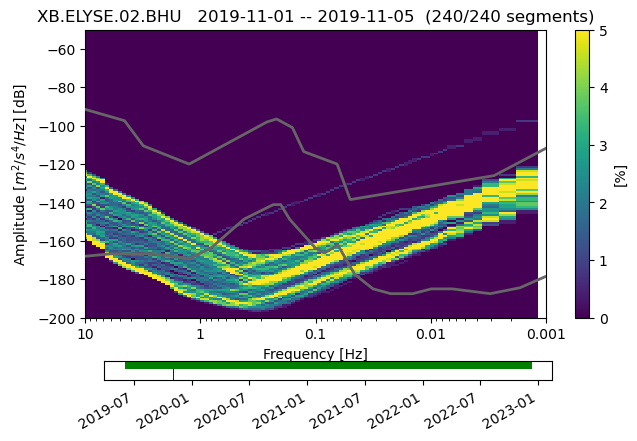

In [75]:
# 배경잡음의 일변화 (2019-10-01 ~ 2019-10-05)

starttime = UTCDateTime("2019-11-01T00:00:00")
endtime = UTCDateTime("2019-11-06T00:00:00")
diurnal_npz = U_component

mask = diurnal_npz._stack_selection(starttime=starttime, endtime=endtime)
diurnal_npz._times_processed = [t for i, t in enumerate(diurnal_npz._times_processed) if mask[i]]
diurnal_npz._binned_psds = [t for i, t in enumerate(diurnal_npz._binned_psds) if mask[i]]
diurnal_npz.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False);

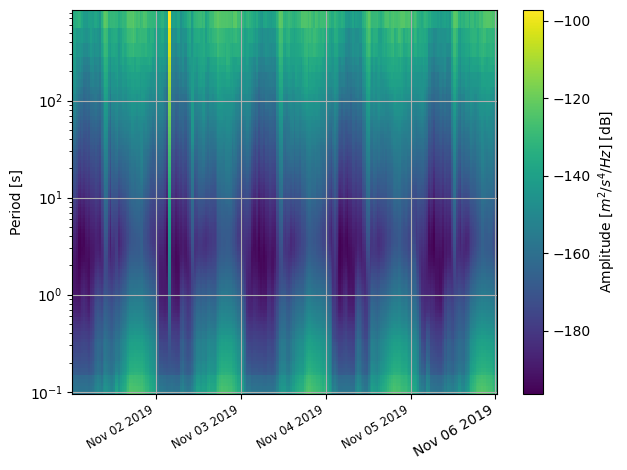

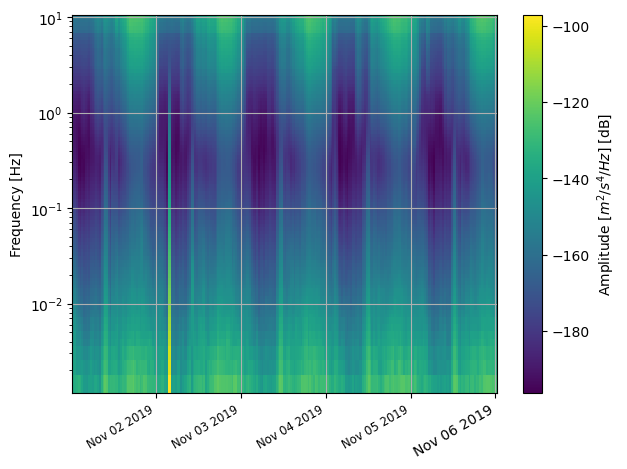

In [76]:
diurnal_npz.plot_spectrogram()
manual_plot_spectrogram(diurnal_npz)

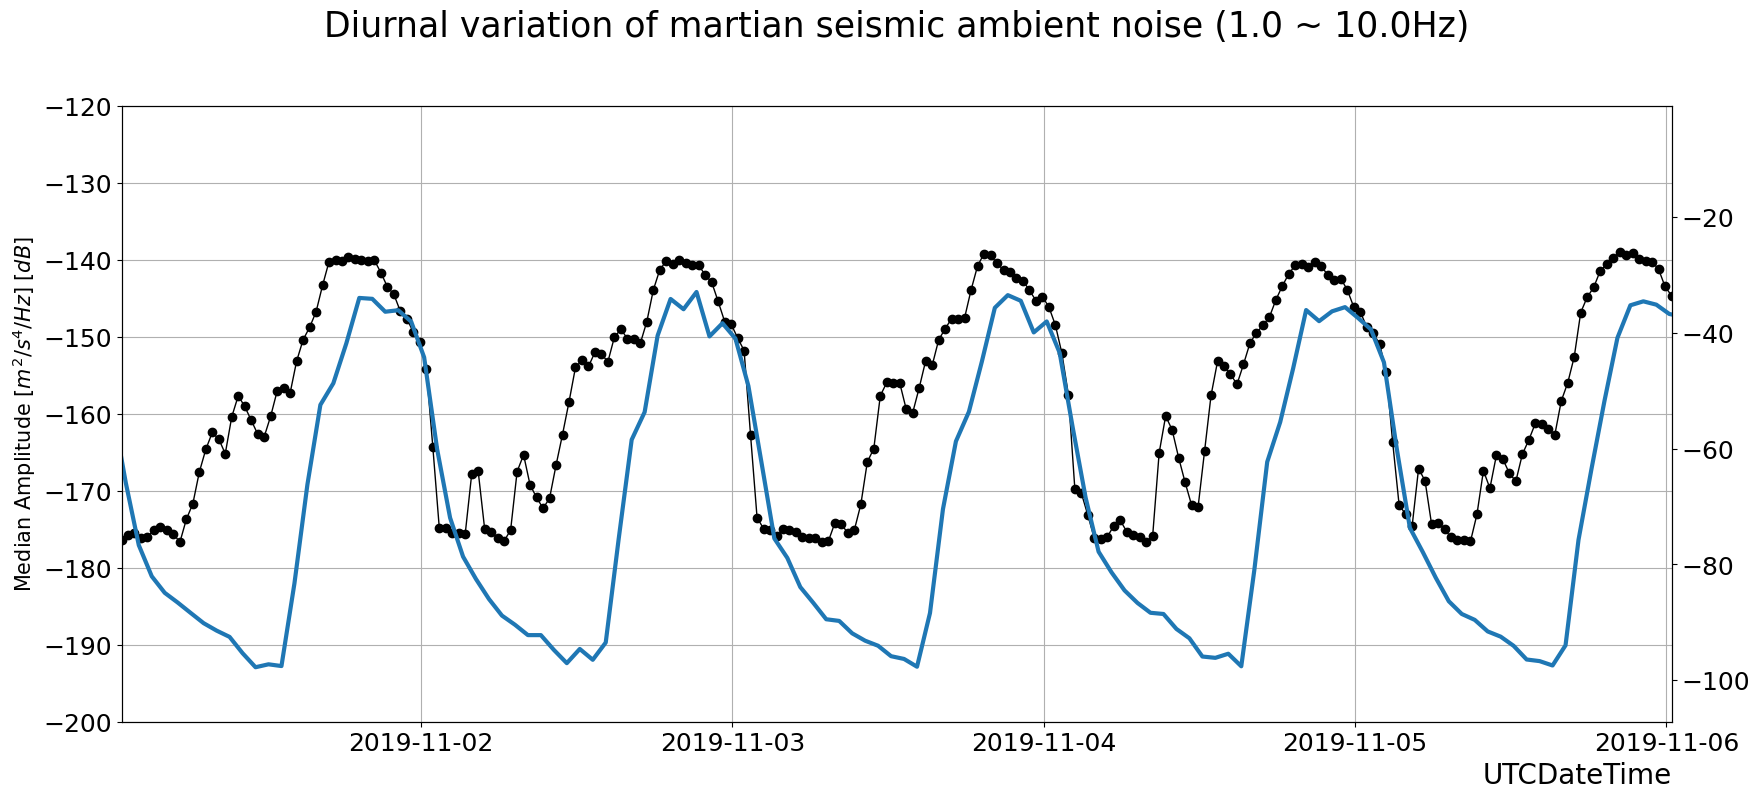

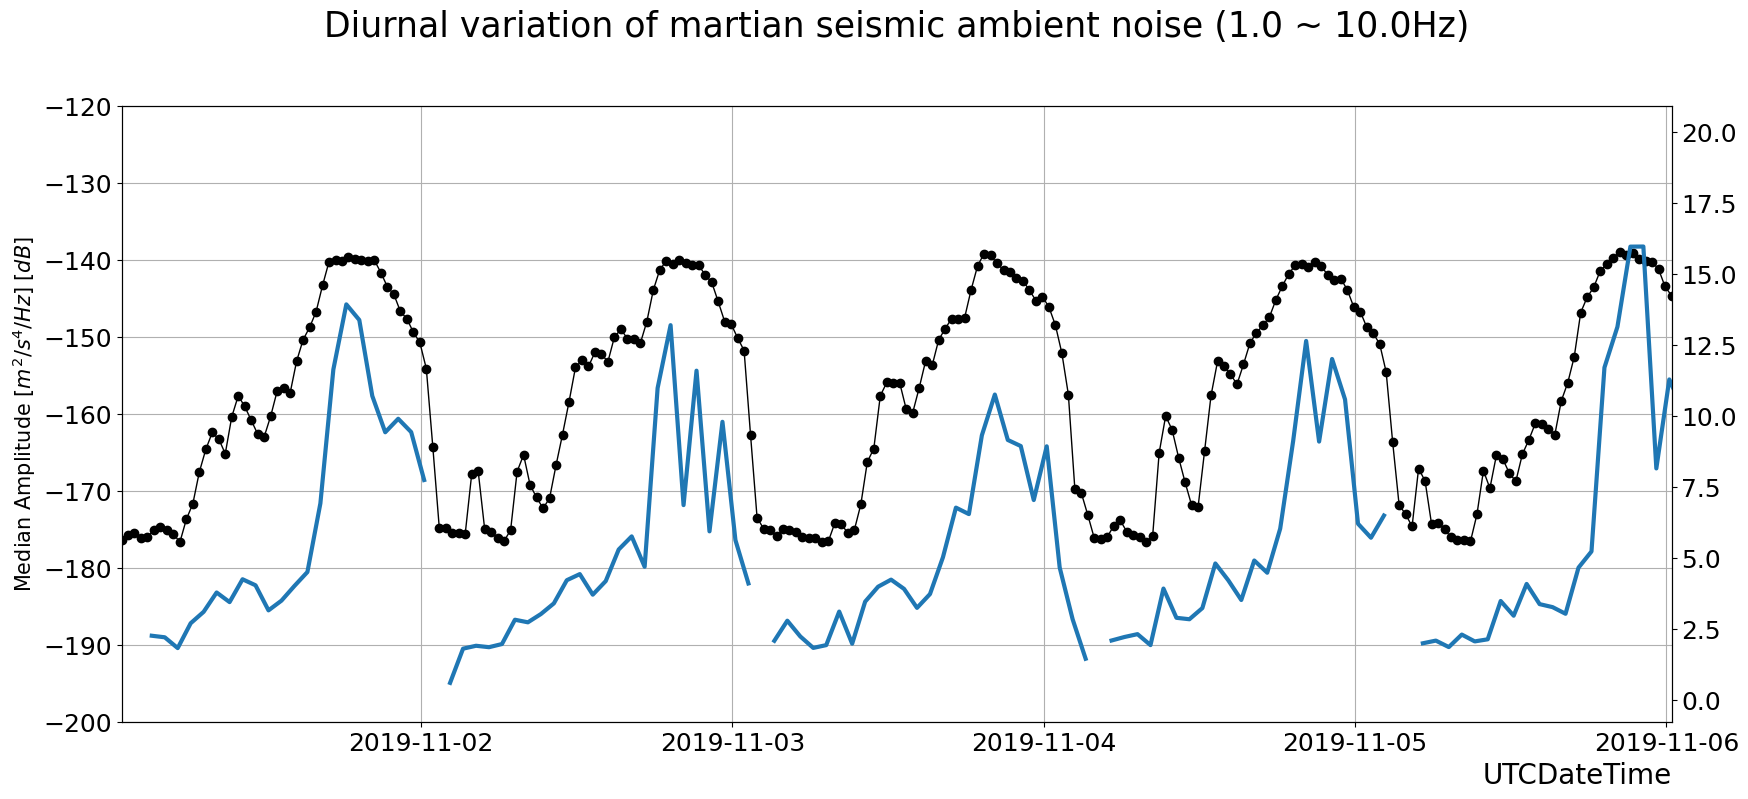

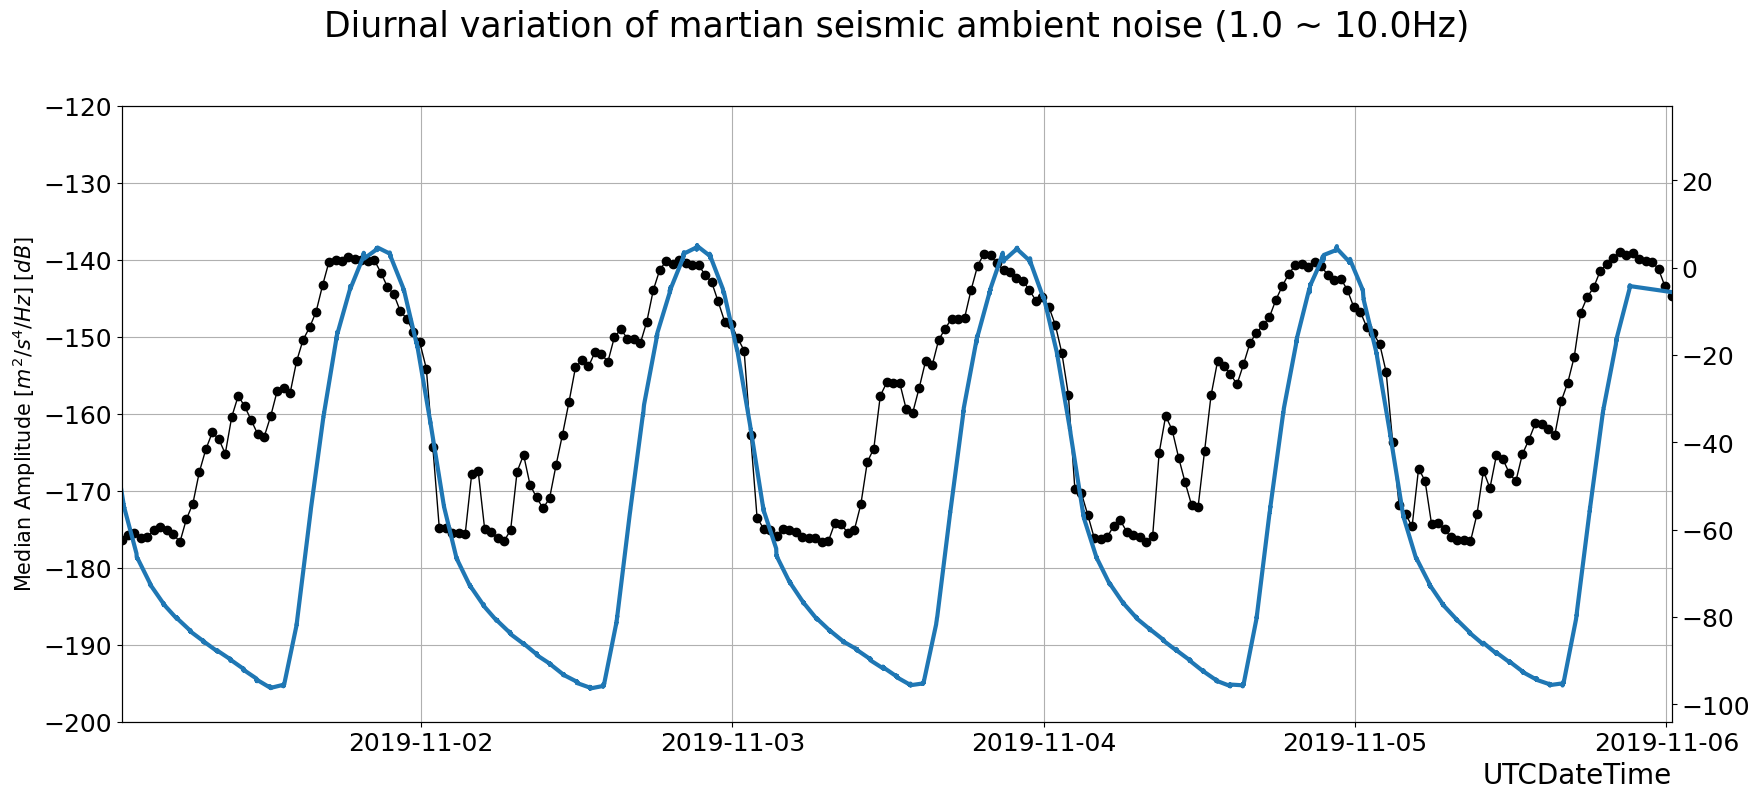

In [78]:
# 주파수 별 배경잡음과 주변 환경 요소의 상관성 비교

'''
# 0.01~0.1Hz
noise_sequence(diurnal_npz, freqmin = 0.01, freqmax = 0.1, title = 'Diurnal variation of martian seismic ambient noise (0.01 ~ 0.1Hz)',
               metadata_x= x, metadata_y=y);
noise_sequence(diurnal_npz, freqmin = 0.01, freqmax = 0.1, title = 'Diurnal variation of martian seismic ambient noise (0.01 ~ 0.1Hz)',
               metadata_x= x, metadata_y=y2);
noise_sequence(diurnal_npz, freqmin = 0.01, freqmax = 0.1, title = 'Diurnal variation of martian seismic ambient noise (0.01 ~ 0.1Hz)',
               metadata_x= x, metadata_y=y3);
#noise_sequence(diurnal_npz, freqmin = 0.01, freqmax = 0.1, title = 'Diurnal variation of martian seismic ambient noise (0.01 ~ 0.1Hz)', metadata_x= x4, metadata_y=y4);
noise_sequence(diurnal_npz, freqmin = 0.01, freqmax = 0.1, title = 'Diurnal variation of martian seismic ambient noise (0.01 ~ 0.1Hz)',
               metadata_x= x5, metadata_y=y5);


noise_sequence(diurnal_npz, freqmin = 0.1, freqmax = 1.0, title = 'Diurnal variation of martian seismic ambient noise (0.1 ~ 1.0Hz)',
               metadata_x= x, metadata_y=y);
noise_sequence(diurnal_npz, freqmin = 0.1, freqmax = 1.0, title = 'Diurnal variation of martian seismic ambient noise (0.1 ~ 1.0Hz)',
               metadata_x= x, metadata_y=y2);
noise_sequence(diurnal_npz, freqmin = 0.1, freqmax = 1.0, title = 'Diurnal variation of martian seismic ambient noise (0.1 ~ 1.0Hz)',
               metadata_x= x, metadata_y=y3);
#noise_sequence(diurnal_npz, freqmin = 0.1, freqmax = 1.0, title = 'Diurnal variation of martian seismic ambient noise (0.1 ~ 1.0Hz)', metadata_x= x4, metadata_y=y4);
noise_sequence(diurnal_npz, freqmin = 0.1, freqmax = 1.0, title = 'Diurnal variation of martian seismic ambient noise (0.1 ~ 1.0Hz)',
               metadata_x= x5, metadata_y=y5);
'''

noise_sequence(diurnal_npz, freqmin = 1.0, freqmax = 10.0, title = 'Diurnal variation of martian seismic ambient noise (1.0 ~ 10.0Hz)', metadata_x= x, metadata_y=y);
noise_sequence(diurnal_npz, freqmin = 1.0, freqmax = 10.0, title = 'Diurnal variation of martian seismic ambient noise (1.0 ~ 10.0Hz)', metadata_x= x, metadata_y=y2);
noise_sequence(diurnal_npz, freqmin = 1.0, freqmax = 10.0, title = 'Diurnal variation of martian seismic ambient noise (1.0 ~ 10.0Hz)', metadata_x= x5, metadata_y=y5);

---
# 화성 계절 데이터

- 여름 : 2019-10-08 ~ 2020-04-07
- 가을 : 2020-04-08 ~ 2020-09-01
- 겨울 : 2020-09-02 ~ 2021-02-06
- 봄 : 2021-02-07 ~ 2021-08-24 

1. 각각의 화성 계절의 PSD로부터 나타나는 특징 확인  

2. PSD에서 계절별로 median 추출해서 PSD 상 총 4개의 곡선으로 도시 → 계절별로 배경잡음의 수준 차이가 나타나는 것 확인  

3. U(V, W)_component로 화성의 1년치 스펙트로그램 or 시간 영역 잡음 도시 → 연변화 확인

In [65]:
spring = PPSD.load_npz('mars_spring.npz')
summer = PPSD.load_npz('mars_summer.npz')
autumn = PPSD.load_npz('mars_autumn.npz')
winter = PPSD.load_npz('mars_winter.npz')

#spring.plot(xaxis_frequency=True, period_lim= (10, 0.001) ,max_percentage=5, grid=False);
#summer.plot(xaxis_frequency=True, period_lim= (10, 0.001) ,max_percentage=5, grid=False);
#autumn.plot(xaxis_frequency=True, period_lim= (10, 0.001) ,max_percentage=5, grid=False);
#winter.plot(xaxis_frequency=True, period_lim= (10, 0.001) ,max_percentage=5, grid=False);

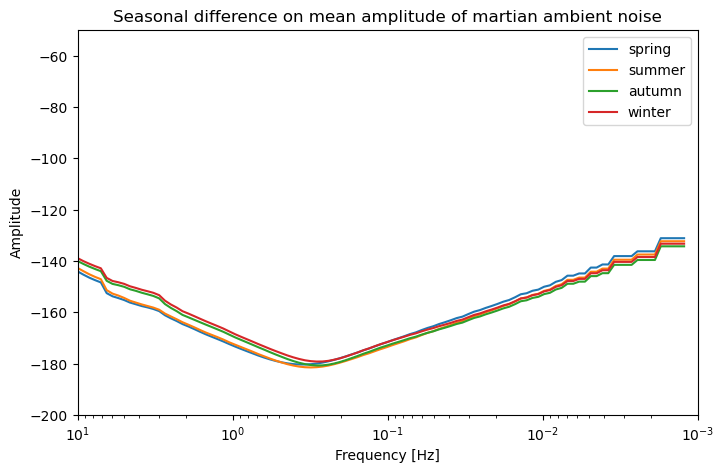

In [66]:
# 계절별 주파수 별 평균 PSD 추출 -> 계절별 배경잡음 세기 비교

spring_mean = spring.get_mean()
summer_mean = summer.get_mean()
autumn_mean = autumn.get_mean()
winter_mean = winter.get_mean()

plt.figure(figsize = (8,5))

plt.plot(1/spring_mean[0], spring_mean[1], label = 'spring')
plt.plot(1/summer_mean[0], summer_mean[1], label = 'summer')
plt.plot(1/autumn_mean[0], autumn_mean[1], label = 'autumn')
plt.plot(1/winter_mean[0], winter_mean[1], label = 'winter')

plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.xlim(10, 0.001)
plt.ylim(-200, -50)
plt.legend(loc = 'best')
plt.title("Seasonal difference on mean amplitude of martian ambient noise")

plt.show()

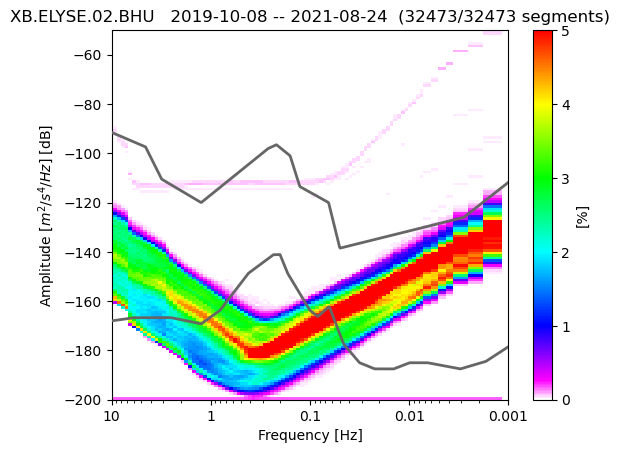

In [14]:
# 시간에 따른 계절별 배경잡음의 변화 (2019-10-08 ~ 2021-08-24)

starttime = UTCDateTime("2019-10-08T00:00:00")
endtime = UTCDateTime("2021-08-25T00:00:00")
U_component_temp = U_component
mask = U_component_temp._stack_selection(starttime=starttime, endtime=endtime)
U_component_temp._times_processed = [t for i, t in enumerate(U_component_temp._times_processed) if mask[i]]
U_component_temp._binned_psds = [t for i, t in enumerate(U_component_temp._binned_psds) if mask[i]]
U_component_temp.plot(xaxis_frequency=True, period_lim= (10, 0.001), max_percentage=5, grid=False, cmap = pqlx, show_coverage= False);

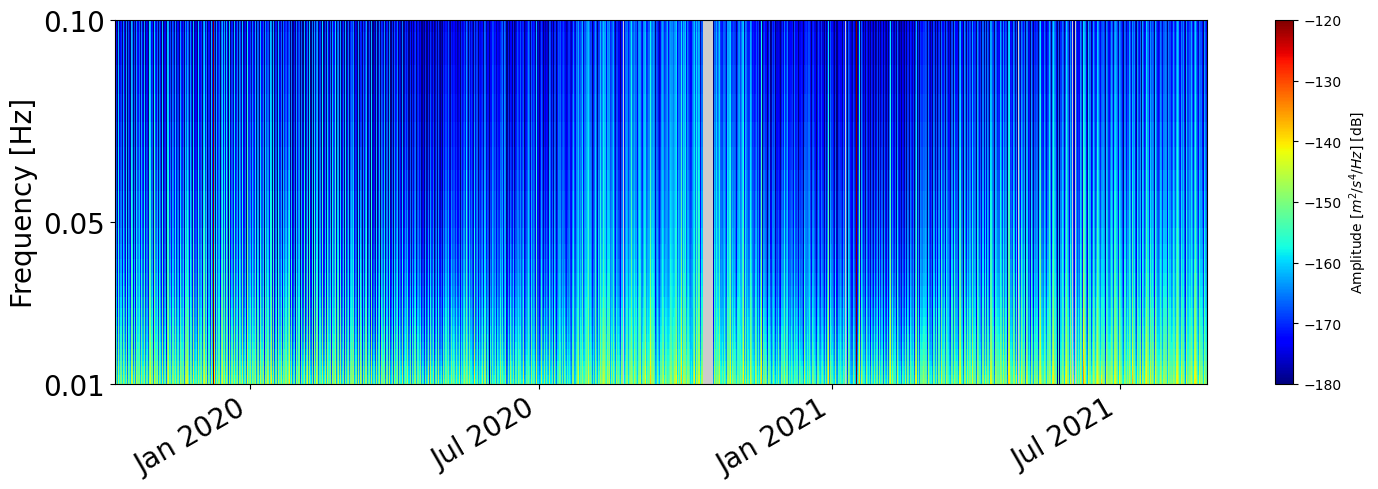

In [15]:
# plotting reversed spectrogram with plot_spectrogram2 function

plot_spectrogram3(U_component_temp, freqmin = 0.01, freqmax = 0.1, grid=False, cmap='jet', clim = [-180, -120], cbticks= [-180,-170,-160,-150,-140,-130,-120]);

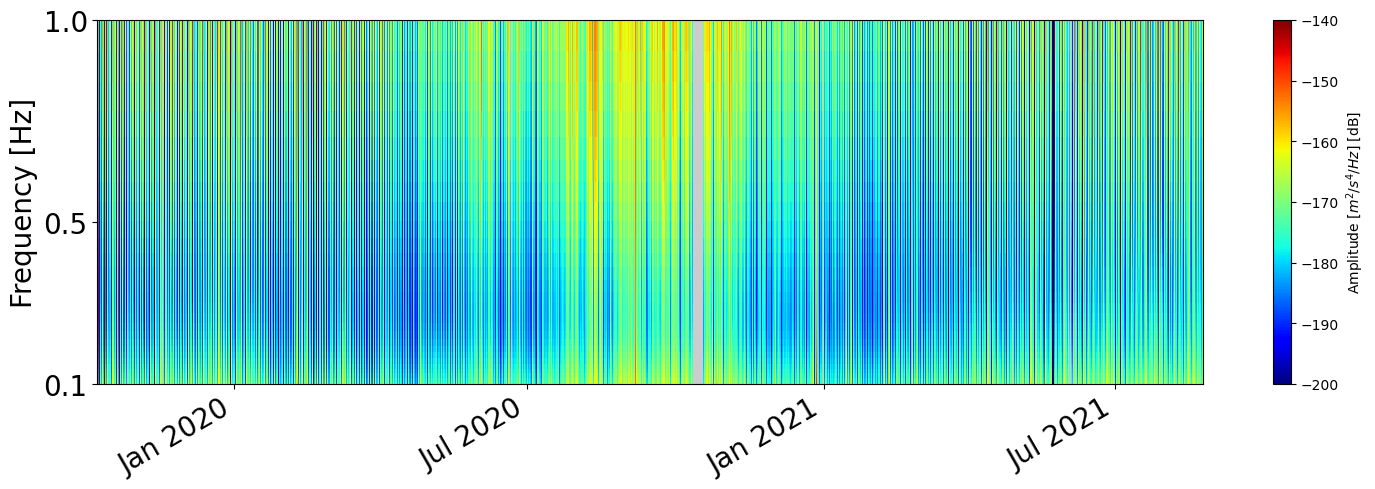

In [18]:
# plotting reversed spectrogram with plot_spectrogram2 function

plot_spectrogram3(U_component_temp, freqmin = 0.1, freqmax = 1.0, grid=False, cmap='jet', clim = [-200, -140], cbticks= [-200,-190,-180,-170,-160,-150,-140]);

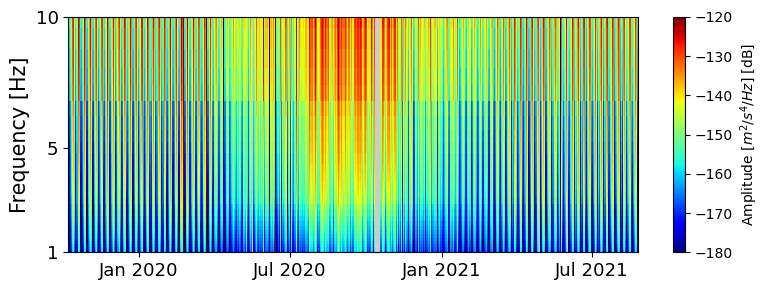

In [158]:
# plotting reversed spectrogram with plot_spectrogram2 function

plot_spectrogram3(U_component_temp, freqmin = 1.0, freqmax = 10.0, grid=False, cmap='jet', clim = [-180, -120], cbticks= [-180,-170,-160,-150,-140,-130,-120]);

2019


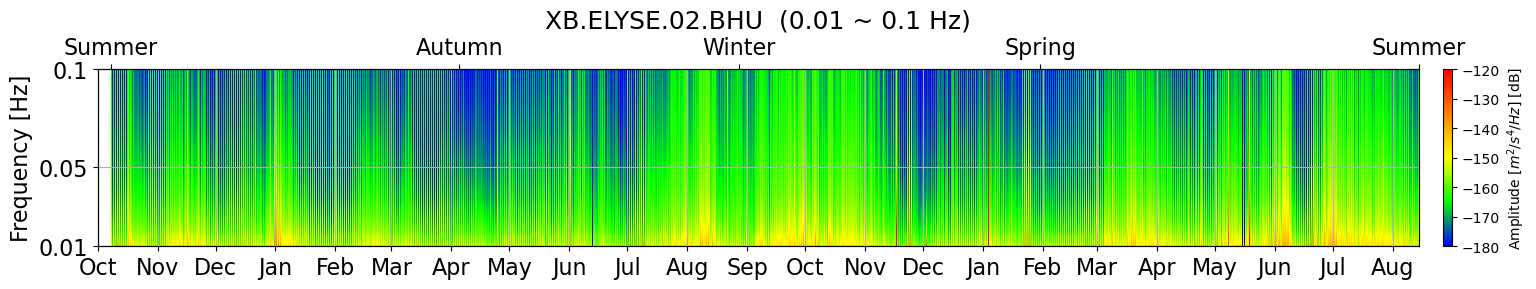

In [672]:
psd_spectrogram(U_component_temp, 'XB.ELYSE.02.BHU  (0.01 ~ 0.1 Hz)', xttype="D", fsize=(17,3), flim=[0.01, 0.1], flist=[0.01, 0.05, 0.1], clim=[-180, -120])

2019


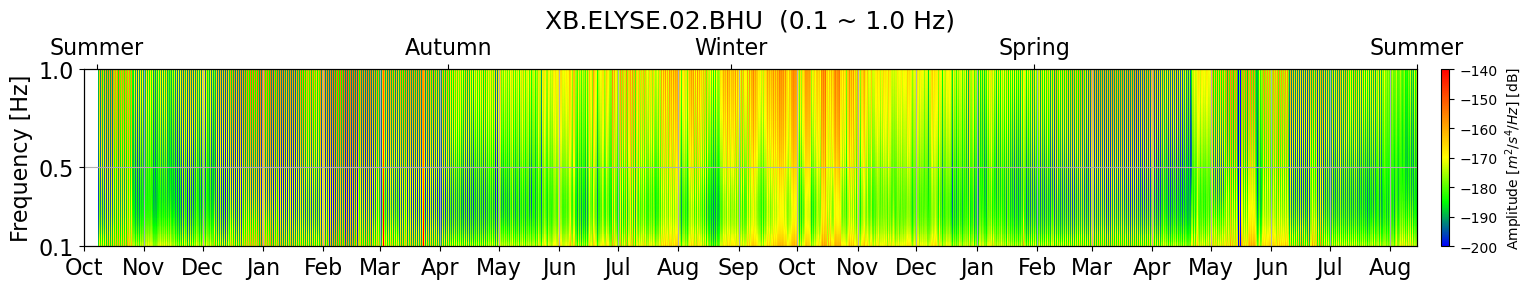

In [673]:
psd_spectrogram(U_component_temp, 'XB.ELYSE.02.BHU  (0.1 ~ 1.0 Hz)', day_inc=30, xttype="D", fsize=(17,3), flim=[0.1, 1.0], flist=[0.1, 0.5, 1.0], clim=[-200, -140])

2019


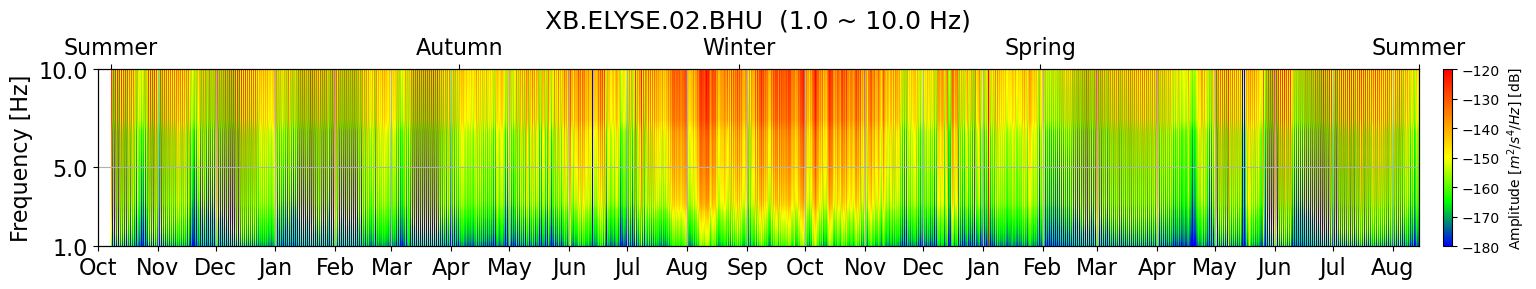

In [674]:
psd_spectrogram(U_component_temp, 'XB.ELYSE.02.BHU  (1.0 ~ 10.0 Hz)', day_inc=30, xttype="D", fsize=(17,3), flim=[1.0, 10.0], flist=[1.0, 5.0, 10.0], clim=[-180, -120])

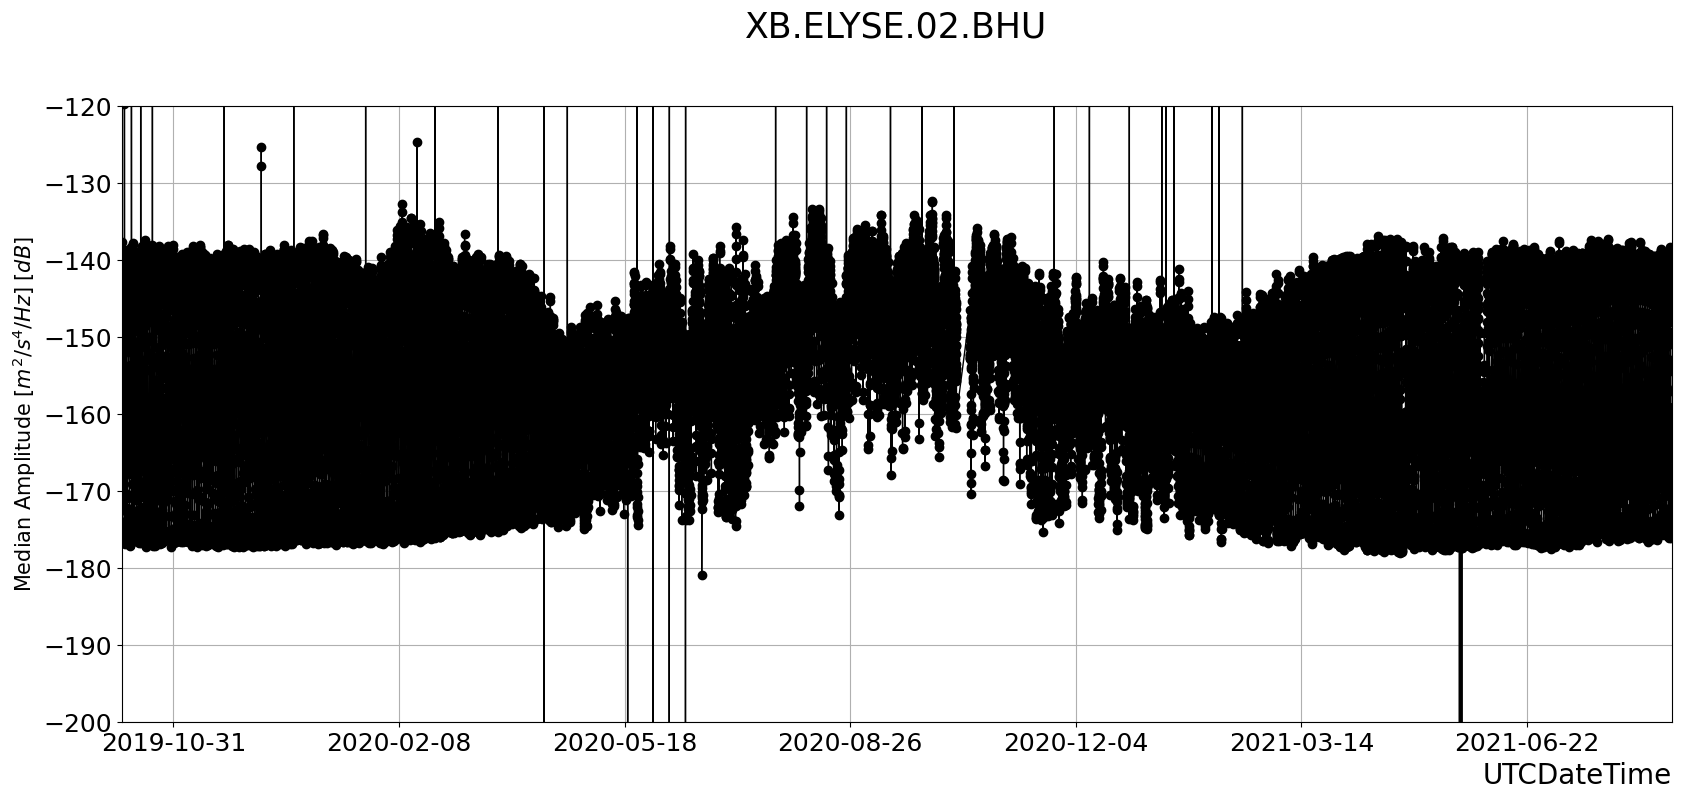

([-140.75519,
  -138.82985,
  -137.71942,
  -138.74666,
  -139.80814,
  -141.06671,
  -141.79903,
  -142.6787,
  -144.22923,
  -144.56578,
  -144.60887,
  -146.2478,
  -146.06798,
  -147.08917,
  -149.52034,
  -152.46683,
  -157.3898,
  -166.46748,
  -171.88483,
  -172.54593,
  -175.13223,
  -174.65486,
  -175.86081,
  -175.21257,
  -174.7596,
  -176.16402,
  -176.19266,
  -176.34749,
  -168.41763,
  -167.03606,
  -168.36528,
  -169.85739,
  -167.8916,
  -167.24432,
  -163.47858,
  -161.20872,
  -160.23973,
  -164.18176,
  -167.241,
  -159.58672,
  -156.28432,
  -158.43753,
  -160.1316,
  -159.38016,
  -154.59714,
  -149.0675,
  -146.76454,
  -145.97437,
  -144.4971,
  -143.87895,
  -143.23268,
  -141.1795,
  -140.09941,
  -140.36644,
  -140.99301,
  -141.95624,
  -141.96748,
  -142.97992,
  -144.52708,
  -144.19962,
  -146.09126,
  -146.54837,
  -113.09723,
  -119.78488,
  -175.22885,
  -176.19063,
  -176.09181,
  -175.64856,
  -176.01512,
  -176.1072,
  -176.30754,
  -176.74907,
  -1

In [82]:
noise_sequence(U_component_temp, freqmin = 1.0, freqmax = 10.0, title = 'XB.ELYSE.02.BHU')

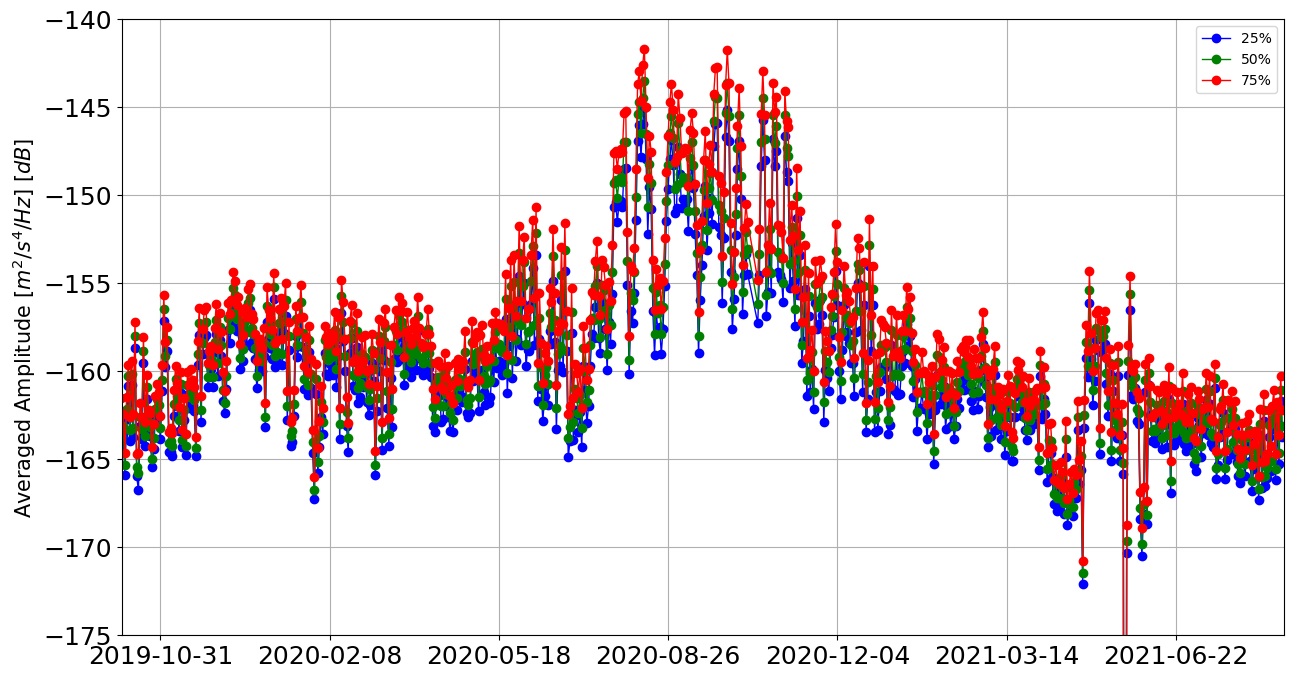

In [177]:
daily_time, daily_avg_amplitude = noise_sequence_daily(U_component_temp, freqmin = 2.0, freqmax = 3.0)

[18177 18179 18181 18183 18185 18187 18189 18191 18193 18195 18197 18199
 18201 18203 18205 18207 18209 18211 18213 18215 18217 18219 18221 18223
 18225 18227 18229 18231 18233 18235 18237 18239 18241 18243 18245 18247
 18249 18251 18253 18255 18257 18259 18261 18263 18265 18267 18269 18271
 18273 18275 18277 18279 18281 18283 18285 18287 18289 18291 18293 18295
 18297 18299 18301 18303 18305 18307 18309 18311 18313 18315 18317 18319
 18321 18323 18325 18327 18329 18331 18333 18335 18337 18339 18341 18343
 18345 18347 18349 18351 18353 18355 18357 18359 18361 18363 18365 18367
 18369 18371 18373 18375 18377 18379 18381 18383 18385 18387 18389 18391
 18393 18395 18397 18399 18401 18403 18405 18407 18409 18411 18413 18415
 18417 18419 18421 18423 18425 18427 18429 18431 18433 18435 18437 18439
 18441 18443 18445 18447 18449 18451 18453 18455 18457 18459 18461 18463
 18465 18467 18469 18471 18473 18475 18477 18479 18481 18483 18485 18487
 18489 18491 18493 18495 18497 18499 18501 18503 18

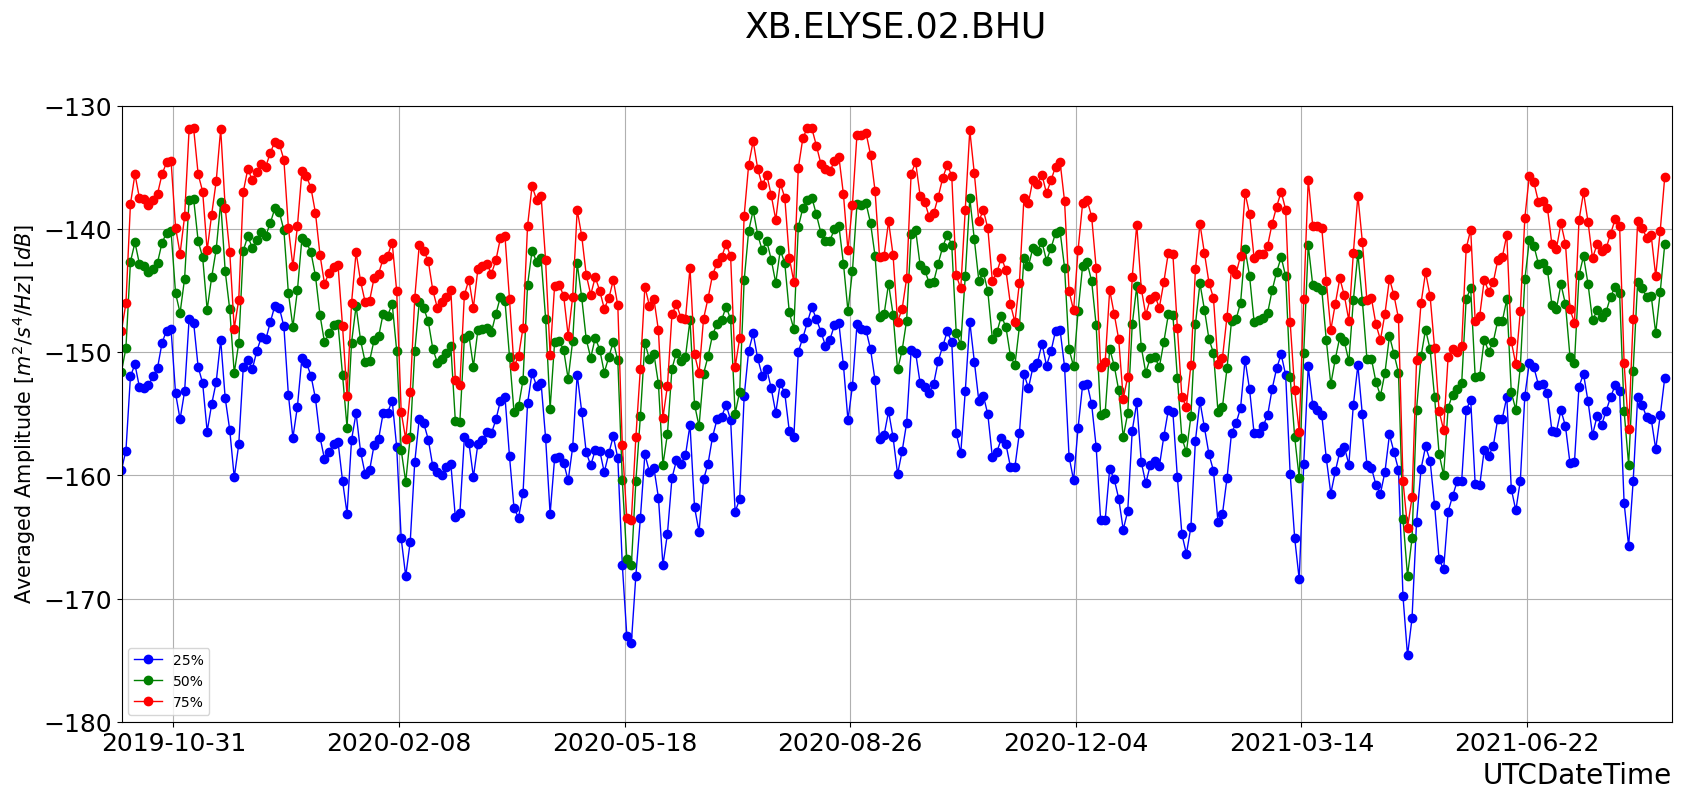

In [37]:
weekly_time = noise_sequence_ma(U_component_temp, target_period = 2, freqmin = 1.0, freqmax = 10.0, title = 'XB.ELYSE.02.BHU')

---
# 연속파형으로부터 주기 계산

- diurnal / seasonal variation이 나타나는 주파수 대역의 배경잡음을 DFT를 이용해 주기 정량적 계산
- 교수님 포스터처럼 푸리에 계수 구해서 피팅해서 하는게?

C:\Users\neimb\AppData\Local\Temp\ipykernel_10396\770767958.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs, np.abs(dft))


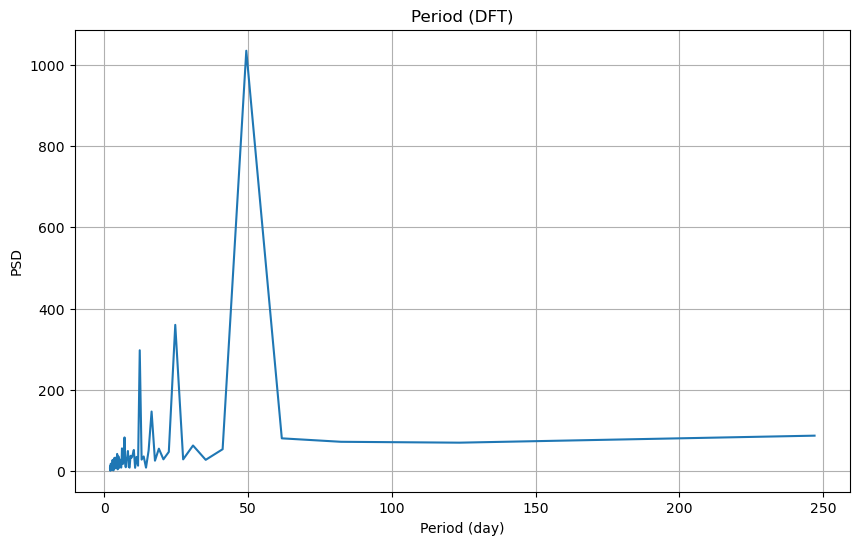

In [164]:
dft = np.fft.rfft(median)
freqs = np.fft.rfftfreq(len(median), d=time[1]-time[0])

plt.figure(figsize=(10, 6))
plt.plot(1/freqs, np.abs(dft))
plt.title('Period (DFT)')
plt.xlabel('Period (day)')
plt.ylabel('PSD')
#plt.xticks([0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
#plt.xlim(0, 10.0)
plt.grid(True)
plt.show()

C:\Users\neimb\AppData\Local\Temp\ipykernel_27880\2447540230.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs, np.abs(dft))


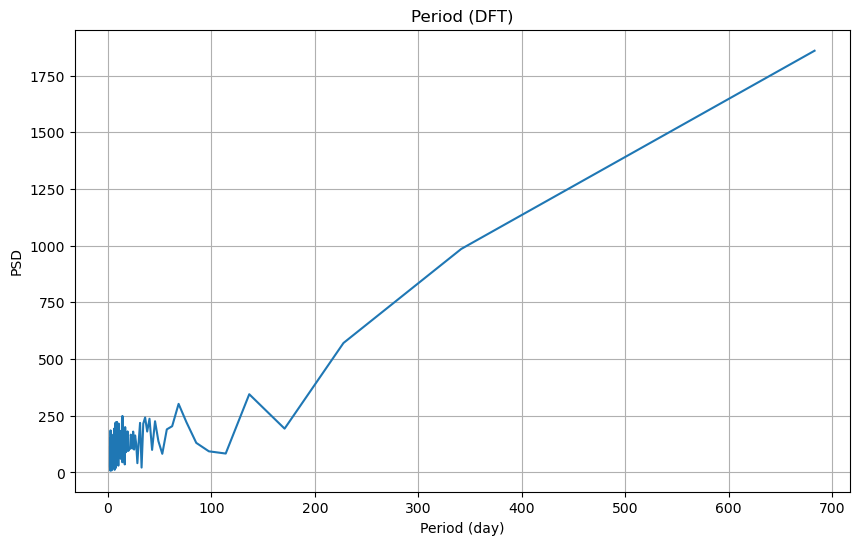

In [124]:
dft = np.fft.rfft(daily_avg_amplitude)
freqs = np.fft.rfftfreq(len(daily_avg_amplitude), d=daily_time[1]-daily_time[0])

plt.figure(figsize=(10, 6))
plt.plot(1/freqs, np.abs(dft))
plt.title('Period (DFT)')
plt.xlabel('Period (day)')
plt.ylabel('PSD')
#plt.xticks([0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
#plt.xlim(0, 10.0)
plt.grid(True)
plt.show()

C:\Users\neimb\AppData\Local\Temp\ipykernel_27880\4263527935.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs, np.abs(dft))


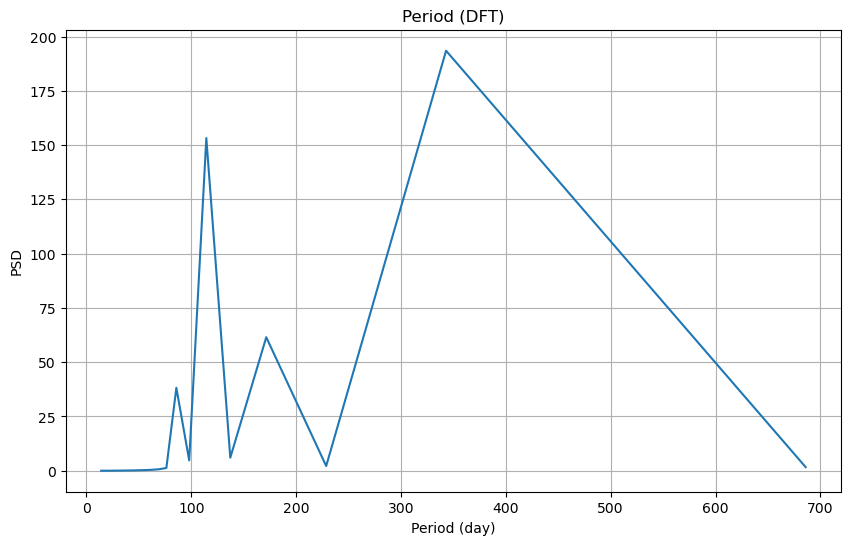

In [166]:
dft = np.fft.rfft(weekly_avg_amplitude)
freqs = np.fft.rfftfreq(len(weekly_avg_amplitude), d=weekly_time[1]-weekly_time[0])

plt.figure(figsize=(10, 6))
plt.plot(1/freqs, np.abs(dft))
plt.title('Period (DFT)')
plt.xlabel('Period (day)')
plt.ylabel('PSD')
#plt.xticks([0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
#plt.xlim(0, 2.0)
plt.grid(True)
plt.show()